# GCTA 

In this notebook, we will use GCTA to calculate the Polygenic Risk Score (PRS).

**Note:** GCTA needs to be installed or placed in the same directory as this notebook.

1. It can be downloaded from this link: [GCTA](https://yanglab.westlake.edu.cn/software/gcta/#Download).
1. We recommend using Linux. In cases where Windows is required due to package installation issues on Linux, we provide the following guidance:

   1. For Windows, use `gcta`.
   2. For Linux, use `./gcta`.

## GCTA Hyperparameters

### Hyperparameters for GCTA performed using PLINK

#### Pruning Parameters

Informs Plink that we wish to perform pruning with a window size of 200 variants, sliding across the genome with a step size of 50 variants at a time, and filter out any SNPs with LD \( r^2 \) higher than 0.25.


```python
1. p_window_size = [200]
2. p_slide_size = [50]
3. p_LD_threshold = [0.25]
```

#### Clumping Parameters

The P-value threshold for an SNP to be included. 1 means to include all SNPs for clumping. SNPs having \( r^2 \) higher than 0.1 with the index SNPs will be removed. SNPs within 200k of the index SNP are considered for clumping.

```python
1. clump_p1 = [1]
2. clump_r2 = [0.1]
3. clump_kb = [200]
```
#### PCA
Pca also affects the results evident from the initial analysis; however, including more PCA overfits the model. 

### Hyperparameters for GCTA

These parameters can be passed to GCTA. GCTA provides two parameters when calculating the PRS as specified in [this link](https://yanglab.westlake.edu.cn/software/gcta/#SBLUP).

1. `--cojo-wind`
2. `--cojo-sblup`

`--cojo-wind` is the same as clumping kb as specified in the documentation [link](https://yanglab.westlake.edu.cn/software/gcta/#SBLUP). We will use the same values for this parameter as `clump_kb`.

`--cojo-sblup` is the input parameter `lambda = m * (1 / h2SNP - 1)` where m is the total number of SNPs used in this analysis (i.e. the number of SNPs in common between the summary data and the reference set), and h2SNP is the proportion of variance in the phenotype explained by all SNPs. h2SNP can be estimated from GCTA-GREML if individual-level data are available or from LD score regression analysis of the summary data.


#### Calculate h2 Heritability

There are multiple ways to calculate heritability, and we considered two methods required for lambda = m * (1 / h2SNP - 1).

##### Using LDpred-2

To calculate h2 using LDpred-2, we followed the [LDpred-2 tutorial](https://choishingwan.github.io/PRS-Tutorial/ldpred/).
The code for this part is in R, as LDpred-2 is in R.

1. Using SNPs from the HapMap as preferred by the authors. The name in the code is `LDpred-2_hapmap`.
2. Using all the SNPs. The name in the code is `LDpred-2_full`.

This approach is computationally expensive, as the correlation between all the SNPs in a specific chromosome is being calculated.

##### Using GCTA

To calculate h2 using GCTA, we followed the [GCTA tutorial](https://yanglab.westlake.edu.cn/software/gcta/#Tutorial).

1. Using only genotype data and phenotype. The name in the code is `GCTA_genotype`.

1. `gcta --bfile FILE  --make-grm --out FILE`
2. `gcta --grm FILE --pheno FILE.PHENP --reml --out FILE`


2. Using genotype data, covariates, and phenotype. The name in the code is `GCTA_genotype_covariate`.

1. `gcta --bfile FILE  --make-grm --out FILE`
2. `gcta --grm FILE --pheno FILE.PHENP  --qcovar  FILE.cov --reml --out FILE`


3. Using genotype data, covariates, PCA, and phenotype. The name in the code is `GCTA_genotype_covariate_pca`.

1. `gcta --bfile FILE  --make-grm --out FILE`
2. `gcta --grm FILE --pheno FILE.PHENP --reml --qcovar  FILE.cov_pca --out FILE`

OR

2. `gcta --grm FILE --pheno FILE.PHENP --reml-no-constrain --qcovar  FILE.cov_pca --out FILE`

**Handling REML Non-convergence:**

In some cases, the REML calculation may not converge ([source](https://gcta.freeforums.net/thread/366/error-log-likelihood-converged)). To address this, the `--reml-no-constrain` flag can be used. However, it's important to note that in such cases, the heritability value might exceed 1, often attributed to sample relatedness ([source](https://www.researchgate.net/post/What_does_it_mean_when_heritability_is_larger_than_1#:~:text=1)%20Heritability%20can%20be%20greater,can%20also%20cause%20this%20result.)).

An alternative approach involves using a flag like `--grm-cutoff 0.025`, similar to Plink's `--rel-cutoff 0.125`. This allows for the exclusion of specific samples, facilitating the recalculation of heritability.

**To handle this issue, we used a simple approach in which we considered the `--reml` flag and calculated the heritability. If the heritability calculation doesn't converge, we used the `--grm-cutoff 0.01` flag and calculated the heritability again. The calculated heritability was then used to estimate the `lambda` for SBLUP.**




```bash
gcta --grm FILE --pheno FILE.PHENP --reml --grm-cutoff 0.025 --qcovar FILE.cov_pca --out FILE
```



Heritability calculated using GCTA and using genotype data, covariates, PCA, and phenotype, and LDpred-2 method using all the methods were almost the same.

 

All GCTA functions generate the following file:

Summary result of REML analysis:

| Source | Variance | SE      |
|--------|----------|---------|
| V(G)   | 0.869695 | 0.790524|
| V(e)   | 0.000001 | 0.787625|
| Vp     | 0.869696 | 0.063776|
| V(G)/Vp| 0.999999 | 0.905632|

h2 = V(G)/Vp

**Some code segments should be used when calculating the PRS, and some steps can be executed separately.**

**When calculating h2 from any of the methods, the number of SNPs included in the analysis varies, and only the most suitable SNPs are being considered for the analysis. Kindly see the output screen for the changes in the number of SNPs or the SNPs being removed.**





#### Using LDpred-2 to Calculate h2

When calculating correlation for h2 calculation using LDpred-2, the following arguments should be passed, which are the same as the clumping parameters. These arguments should be passed to the R file when calculating h2.

1. `size = clump_kb = [200]`
   For one SNP, window size around this SNP to compute correlations. Default is 500. If not providing infos.pos (NULL, the default), this is a window in the number of SNPs, otherwise, it is a window in kb (genetic distance).

2. `alpha = clump_p1 = [1]`
   Type-I error for testing correlations. Default is 1 (no threshold is applied).

3. `thr_r2 = clump_r2 = [0.1]`
   Threshold to apply on squared correlations. Default is 0.

The above information is taken from:

```R
library(bigsnpr)
options(bigstatsr.check.parallel.blas = FALSE)
options(default.nproc.blas = NULL)
library(data.table)
library(magrittr)
help(snp_cor)
```
```R
The following code shows the process to calcuate the h2 using LDpred-2.

Actual code in `GCTA_R_1.R`

##### Arguments
1. Argument one is the directory. Example: `SampleData1`
2. Argument two is the file name. Example: `SampleData1\\Fold_0`
3. Argument three is the output file name. Example: `train_data`
4. Argument four is the specific function to be called. Example: `train_data.QC.clumped.pruned`

5. Argument five is LDpred-2 option. Example: `LDpred-2_full` or `LDpred-2_hapmap`
6. Argument six is the size parameter. Example: `200`
7. Argument seven is the alpha parameter. Example: `1`
8. Argument eight is the thr_r2 parameter. Example: `0.1`
9. Argument nine is the number of PCA. Example: `6`

###### Sample values
1. "SampleData1"
2. "SampleData1\\Fold_0"
3. "train_data"
4. "train_data.QC.clumped.pruned"
5. "2"
6. "200"
7. "1"
8. "0.1"
9. "6"

```


##### `LDpred-2_hapmap`

```R
  # Load libraries.
  library(bigsnpr)
  options(bigstatsr.check.parallel.blas = FALSE)
  options(default.nproc.blas = NULL)
  library(data.table)
  library(magrittr)
  # Load phenotype file.
  result <-paste(".",args[2],paste(args[3],toString(".PHENO"), sep = ""),sep="//")
  phenotype <- fread(result)
  # Load covariate file.
  result <-paste(".",args[2],paste(args[3],toString(".cov"), sep = ""),sep="//")
  covariate <- fread(result)
  # Load PCA.
  result <-paste(".",args[2],paste(args[3],toString(".eigenvec"), sep = ""),sep="//")
  pcs <- fread(result)
  # Rename columns
  colnames(pcs) <- c("FID","IID", paste0("PC",1:as.numeric(args[9])))
  # Merge phenotype, covariate and PCA.
  pheno <- merge(phenotype, covariate) %>%
    merge(., pcs)
  # Download hapmap information from LDpred-2
  info <- readRDS(runonce::download_file(
    "https://ndownloader.figshare.com/files/25503788",
    fname = "map_hm3_ldpred2.rds"))
  # Read in the summary statistic file
  result <-paste(".",args[1],paste(args[1],toString(".txt"), sep = ""),sep="//")
  
  sumstats <- bigreadr::fread2(result) 
  # LDpred 2 require the header to follow the exact naming
  names(sumstats) <-
    c("chr",
      "pos",
      "rsid",
      "a1",
      "a0",
      "n_eff",
      "beta_se",
      "p",
      "OR",
      "INFO",
      "MAF")
  # Transform the OR into log(OR)
  sumstats$beta <- log(sumstats$OR)
  # Filter out hapmap SNPs
  # Restrict analysis to SNPs common in Hapmap SNPs and summmary file SNPs.
  sumstats <- sumstats[sumstats$rsid%in% info$rsid,]
  
  # Get maximum amount of cores
  NCORES <- nb_cores()
  # Open a temporary file
  
  if (dir.exists("tmp-data")) {
    # Delete the directory and its contents
    system(paste("rm -r", shQuote("tmp-data")))
    print(paste("Directory", "tmp-data", "deleted."))
  }
  tmp <- tempfile(tmpdir = "tmp-data")
  on.exit(file.remove(paste0(tmp, ".sbk")), add = TRUE)
  # Initialize variables for storing the LD score and LD matrix
  corr <- NULL
  ld <- NULL
  # We want to know the ordering of samples in the bed file 
  fam.order <- NULL
  # Preprocess the bed file (only need to do once for each data set)
  result <-paste(".",args[2],paste(args[4],toString(".rds"), sep = ""),sep="//")
  if (file.exists(result)) {
    file.remove(result)
    print(paste("File", result, "deleted."))
  }
  result <-paste(".",args[2],paste(args[4],toString(".bk"), sep = ""),sep="//")
  if (file.exists(result)) {
    file.remove(result)
    print(paste("File", result, "deleted."))
  }
  
  
  result <-paste(".",args[2],paste(args[4],toString(".bed"), sep = ""),sep="//")
  
  snp_readBed(result)
  # Now attach the genotype object
  result <-paste(".",args[2],paste(args[4],toString(".rds"), sep = ""),sep="//")
  
  obj.bigSNP <- snp_attach(result)
  
  # Extract the SNP information from the genotype
  map <- obj.bigSNP$map[-3]
 
  names(map) <- c("chr", "rsid", "pos", "a1", "a0")
 
  # perform SNP matching
  info_snp <- snp_match(sumstats, map)
  help(snp_match)
  info_snp
  # Assign the genotype to a variable for easier downstream analysis
  genotype <- obj.bigSNP$genotypes
  # Rename the data structures
  CHR <- map$chr
  POS <- map$pos
  # get the CM information from 1000 Genome
  # will download the 1000G file to the current directory (".")
  #help(snp_asGeneticPos)
  POS2 <- snp_asGeneticPos(CHR, POS, dir = ".")
 
  
  for (chr in 1:22) {
    # Extract SNPs that are included in the chromosome
    
    ind.chr <- which(info_snp$chr == chr)
    print(length(ind.chr))
    ind.chr2 <- info_snp$`_NUM_ID_`[ind.chr]
    ind.chr2
    print(length(ind.chr2))
    
    # Calculate the LD
    help(snp_cor)
    corr0 <- snp_cor(
      genotype,
      ind.col = ind.chr2,
      ncores = NCORES,
      infos.pos = POS2[ind.chr2],
      #size = 200,
      #thr_r2=0.1,
      #alpha = 1
      
      size = as.numeric(args[6]),
      alpha = as.numeric(args[7]),
      
      thr_r2=as.numeric(args[8]),
        )
    if (chr == 1) {
      ld <- Matrix::colSums(corr0^2)
      help(as_SFBM)
      corr <- as_SFBM(corr0, tmp)
    } else {
      ld <- c(ld, Matrix::colSums(corr0^2))
      corr$add_columns(corr0, nrow(corr))
    }
  }
  
  
  # We assume the fam order is the same across different chromosomes
  fam.order <- as.data.table(obj.bigSNP$fam)
  # Rename fam order
  setnames(fam.order,
           c("family.ID", "sample.ID"),
           c("FID", "IID"))
  
  df_beta <- info_snp[,c("beta", "beta_se", "n_eff", "_NUM_ID_")]
  
  length(df_beta$beta) 
  length(ld)
  help(snp_ldsc)
  ldsc <- snp_ldsc(ld, 
                   length(ld), 
                   chi2 = (df_beta$beta / df_beta$beta_se)^2,
                   sample_size = df_beta$n_eff, 
                   blocks = NULL)
  h2_est <- ldsc[["h2"]]
  h2_est
  
  if (file.exists("ldpred_h2_hapmap.txt")) {
    file.remove("ldpred_h2_hapmap.txt")
    print(paste("File", result, "deleted."))
  }
  write.table(h2_est, file = "ldpred_h2_hapmap.txt", col.names = FALSE)
  
  if (file.exists("ldpred_h2_variants.txt")) {
    file.remove("ldpred_h2_variants.txt")
    print(paste("File", result, "deleted."))
  }
  write.table(length(ld), file = "ldpred_h2_variants.txt", col.names = FALSE)
```




#### `LDpred-2_full`


```R
  library(bigsnpr)
  options(bigstatsr.check.parallel.blas = FALSE)
  options(default.nproc.blas = NULL)
  library(data.table)
  library(magrittr)
  result <-paste(".",args[2],paste(args[3],toString(".PHENO"), sep = ""),sep="//")
  phenotype <- fread(result)
  result <-paste(".",args[2],paste(args[3],toString(".cov"), sep = ""),sep="//")
  covariate <- fread(result)
  result <-paste(".",args[2],paste(args[3],toString(".eigenvec"), sep = ""),sep="//")
  pcs <- fread(result)
  # rename columns
  colnames(pcs) <- c("FID","IID", paste0("PC",1:as.numeric(args[9])))
  # generate required table
  pheno <- merge(phenotype, covariate) %>%
    merge(., pcs)
  info <- readRDS(runonce::download_file(
    "https://ndownloader.figshare.com/files/25503788",
    fname = "map_hm3_ldpred2.rds"))
  # Read in the summary statistic file
  result <-paste(".",args[1],paste(args[1],toString(".txt"), sep = ""),sep="//")
  
  sumstats <- bigreadr::fread2(result) 
  # LDpred 2 require the header to follow the exact naming
  names(sumstats) <-
    c("chr",
      "pos",
      "rsid",
      "a1",
      "a0",
      "n_eff",
      "beta_se",
      "p",
      "OR",
      "INFO",
      "MAF")
  # Transform the OR into log(OR)
  sumstats$beta <- log(sumstats$OR)
  # Filter out hapmap SNPs
  # Turn off this line to ensure that all the SNPs from the sumstats are included.
  # Restrict analysis to SNPs common in Hapmap SNPs and summmary file SNPs
  #sumstats <- sumstats[sumstats$rsid%in% info$rsid,]
  
  # Get maximum amount of cores
  NCORES <- nb_cores()
  # Open a temporary file
  
  if (dir.exists("tmp-data")) {
    # Delete the directory and its contents
    
    system(paste("rm -r", shQuote("tmp-data")))
    print(paste("Directory", "tmp-data", "deleted."))
  }
  tmp <- tempfile(tmpdir = "tmp-data")
  on.exit(file.remove(paste0(tmp, ".sbk")), add = TRUE)
  # Initialize variables for storing the LD score and LD matrix
  corr <- NULL
  ld <- NULL
  # We want to know the ordering of samples in the bed file 
  fam.order <- NULL
  # preprocess the bed file (only need to do once for each data set)
  result <-paste(".",args[2],paste(args[4],toString(".rds"), sep = ""),sep="//")
  if (file.exists(result)) {
    file.remove(result)
    print(paste("File", result, "deleted."))
  }
  result <-paste(".",args[2],paste(args[4],toString(".bk"), sep = ""),sep="//")
  if (file.exists(result)) {
    file.remove(result)
    print(paste("File", result, "deleted."))
  }
  
  
  result <-paste(".",args[2],paste(args[4],toString(".bed"), sep = ""),sep="//")
  
  snp_readBed(result)
  # now attach the genotype object
  result <-paste(".",args[2],paste(args[4],toString(".rds"), sep = ""),sep="//")
  
  obj.bigSNP <- snp_attach(result)
  
  # extract the SNP information from the genotype
  map <- obj.bigSNP$map[-3]
  
  names(map) <- c("chr", "rsid", "pos", "a1", "a0")
  
  # perform SNP matching
  info_snp <- snp_match(sumstats, map)
  help(snp_match)
  info_snp
  # Assign the genotype to a variable for easier downstream analysis
  genotype <- obj.bigSNP$genotypes
  # Rename the data structures
  CHR <- map$chr
  POS <- map$pos
  # get the CM information from 1000 Genome
  # will download the 1000G file to the current directory (".")
  #help(snp_asGeneticPos)
  POS2 <- snp_asGeneticPos(CHR, POS, dir = ".")
  
  
  for (chr in 1:22) {
    # Extract SNPs that are included in the chromosome
    
    ind.chr <- which(info_snp$chr == chr)
    print(length(ind.chr))
    ind.chr2 <- info_snp$`_NUM_ID_`[ind.chr]
 
    print(length(ind.chr2))
    
    # Calculate the LD
    help(snp_cor)
    corr0 <- snp_cor(
      genotype,
      ind.col = ind.chr,
      ncores = NCORES,
      infos.pos = POS2[ind.chr2],
      #size = 200,
      #thr_r2=0.1,
      #alpha = 1
      
      size = as.numeric(args[6]),
      alpha = as.numeric(args[7]),
      thr_r2=as.numeric(args[8]),
    )
    if (chr == 1) {
      ld <- Matrix::colSums(corr0^2)
      help(as_SFBM)
      corr <- as_SFBM(corr0, tmp)
    } else {
      ld <- c(ld, Matrix::colSums(corr0^2))
      corr$add_columns(corr0, nrow(corr))
    }
  }
  
  
  # We assume the fam order is the same across different chromosomes
  fam.order <- as.data.table(obj.bigSNP$fam)
  # Rename fam order
  setnames(fam.order,
           c("family.ID", "sample.ID"),
           c("FID", "IID"))
  
  df_beta <- info_snp[,c("beta", "beta_se", "n_eff", "_NUM_ID_")]
  
  length(df_beta$beta) 
  length(ld)
  help(snp_ldsc)
  ldsc <- snp_ldsc(ld, 
                   length(ld), 
                   chi2 = (df_beta$beta / df_beta$beta_se)^2,
                   sample_size = df_beta$n_eff, 
                   blocks = NULL)
  h2_est <- ldsc[["h2"]]
 
  
  if (file.exists("ldpred_h2_full.txt")) {
    file.remove("ldpred_h2_full.txt")
    print(paste("File", result, "deleted."))
  }
  
  write.table(h2_est, file = "ldpred_h2_full.txt", col.names = FALSE)
``` 
 
 

### GWAS File Processing for GCTA

GCTA requires GWAS file in a specific format as specified in this document https://yanglab.westlake.edu.cn/software/gcta/#COJO. The GWAS we have contains all the required columns for processing.

 


In [1]:
import os
import pandas as pd
import numpy as np
import sys
import os
import pandas as pd
import numpy as np

def check_phenotype_is_binary_or_continous(filedirec):
    # Read the processed quality controlled file for a phenotype
    df = pd.read_csv(filedirec+os.sep+filedirec+'_QC.fam',sep="\s+",header=None)
    column_values = df[5].unique()
 
    if len(set(column_values)) == 2:
        return "Binary"
    else:
        return "Continous"

    
#filedirec = sys.argv[1]

filedirec = "SampleData1"
#filedirec = "asthma_19"
#filedirec = "migraine_0"




# Read the GWAS file.
GWAS = filedirec + os.sep + filedirec+".gz"
df = pd.read_csv(GWAS,compression= "gzip",sep="\s+")

if check_phenotype_is_binary_or_continous(filedirec)=="Binary":
    if "BETA" in df.columns.to_list():
        # For Binary Phenotypes.
        df["OR"] = np.exp(df["BETA"])
        df = df[['CHR', 'BP', 'SNP', 'A1', 'A2', 'N', 'SE', 'P', 'OR', 'INFO', 'MAF']]
 
    else:
        # For Binary Phenotype.
        df = df[['CHR', 'BP', 'SNP', 'A1', 'A2', 'N', 'SE', 'P', 'OR', 'INFO', 'MAF']]
        
    # Transform the GWAS as required by GCTA.
    df_transformed = pd.DataFrame({
        'SNP': df['SNP'],
        'A1': df['A1'],
        'A2': df['A2'],
        'freq': df['MAF'],
        'b': df['OR'],
        'se': df['SE'],
        'p': df['P'],
        'N': df['N']
    })
        
        
        
elif check_phenotype_is_binary_or_continous(filedirec)=="Continous":
    if "BETA" in df.columns.to_list():
        # For Continous Phenotype.
        df = df[['CHR', 'BP', 'SNP', 'A1', 'A2', 'N', 'SE', 'P', 'BETA', 'INFO', 'MAF']]

    else:
        df["BETA"] = np.log(df["OR"])
        df = df[['CHR', 'BP', 'SNP', 'A1', 'A2', 'N', 'SE', 'P', 'BETA', 'INFO', 'MAF']]
    df_transformed = pd.DataFrame({
            'SNP': df['SNP'],
            'A1': df['A1'],
            'A2': df['A2'],
            'freq': df['MAF'],
            'b': df['BETA'],
            'se': df['SE'],
            'p': df['P'],
            'N': df['N']
    })
 

# Save this file as it is being required by GCTA.
output_file = filedirec + os.sep +filedirec+"_GCTA.txt"   
df_transformed.to_csv(output_file,sep="\t",index=False)
print(df_transformed.head().to_markdown())
print("Length of DataFrame!",len(df_transformed))
 

# Save this file as it is being required for LDpred-2 for heritability calculation to calculate the heritability required by GCTA.
# Save this file that contains just betas even for binary phenotypes.

if "BETA" in df.columns.to_list():
    # For Continous Phenotype.
    df = df[['CHR', 'BP', 'SNP', 'A1', 'A2', 'N', 'SE', 'P', 'BETA', 'INFO', 'MAF']]

else:
    df["BETA"] = np.log(df["OR"])
    df = df[['CHR', 'BP', 'SNP', 'A1', 'A2', 'N', 'SE', 'P', 'BETA', 'INFO', 'MAF']]

df.to_csv(filedirec + os.sep +filedirec+".txt",sep="\t",index=False)
print(df.head().to_markdown())
print("Length of DataFrame!",len(df))



 
 

|    | SNP        | A1   | A2   |     freq |           b |         se |        p |      N |
|---:|:-----------|:-----|:-----|---------:|------------:|-----------:|---------:|-------:|
|  0 | rs3131962  | A    | G    | 0.36939  | -0.00211532 | 0.00301666 | 0.483171 | 388028 |
|  1 | rs12562034 | A    | G    | 0.336846 |  0.00068708 | 0.00329472 | 0.834808 | 388028 |
|  2 | rs4040617  | G    | A    | 0.377368 | -0.00239932 | 0.00303344 | 0.42897  | 388028 |
|  3 | rs79373928 | G    | T    | 0.483212 |  0.00203363 | 0.00841324 | 0.808999 | 388028 |
|  4 | rs11240779 | G    | A    | 0.45041  |  0.00130747 | 0.00242821 | 0.590265 | 388028 |
Length of DataFrame! 499617
|    |   CHR |     BP | SNP        | A1   | A2   |      N |         SE |        P |        BETA |     INFO |      MAF |
|---:|------:|-------:|:-----------|:-----|:-----|-------:|-----------:|---------:|------------:|---------:|---------:|
|  0 |     1 | 756604 | rs3131962  | A    | G    | 388028 | 0.00301666 | 0.483171 | -0.0

### Define Hyperparameters

Define hyperparameters to be optimized and set initial values.

### Extract Valid SNPs from Clumped File

For Windows, download `gwak`, and for Linux, the `awk` command is sufficient. For Windows, `GWAK` is required. You can download it from [here](https://sourceforge.net/projects/gnuwin32/). Get it and place it in the same directory.


### Execution Path

At this stage, we have the genotype training data `newtrainfilename = "train_data.QC"` and genotype test data `newtestfilename = "test_data.QC"`.

We modified the following variables:

1. `filedirec = "SampleData1"` or `filedirec = sys.argv[1]`
2. `foldnumber = "0"` or `foldnumber = sys.argv[2]` for HPC.

Only these two variables can be modified to execute the code for specific data and specific folds. Though the code can be executed separately for each fold on HPC and separately for each dataset, it is recommended to execute it for multiple diseases and one fold at a time.
Here’s the corrected text in Markdown format:

 
### P-values

PRS calculation relies on P-values. SNPs with low P-values, indicating a high degree of association with a specific trait, are considered for calculation.

You can modify the code below to consider a specific set of P-values and save the file in the same format.

We considered the following parameters:

- **Minimum P-value**: `1e-10`
- **Maximum P-value**: `1.0`
- **Minimum exponent**: `10`  (Minimum P-value in exponent)
- **Number of intervals**: `100`  (Number of intervals to be considered)

The code generates an array of logarithmically spaced P-values:

```python
import numpy as np
import os

minimumpvalue = 10  # Minimum exponent for P-values
numberofintervals = 100  # Number of intervals to be considered

allpvalues = np.logspace(-minimumpvalue, 0, numberofintervals, endpoint=True)  # Generating an array of logarithmically spaced P-values

print("Minimum P-value:", allpvalues[0])
print("Maximum P-value:", allpvalues[-1])

count = 1
with open(os.path.join(folddirec, 'range_list'), 'w') as file:
    for value in allpvalues:
        file.write(f'pv_{value} 0 {value}\n')  # Writing range information to the 'range_list' file
        count += 1

pvaluefile = os.path.join(folddirec, 'range_list')
```

In this code:
- `minimumpvalue` defines the minimum exponent for P-values.
- `numberofintervals` specifies how many intervals to consider.
- `allpvalues` generates an array of P-values spaced logarithmically.
- The script writes these P-values to a file named `range_list` in the specified directory.
 

In [2]:
from operator import index
import pandas as pd
import numpy as np
import os
import subprocess
import sys
import pandas as pd
import statsmodels.api as sm
import pandas as pd
from sklearn.metrics import roc_auc_score, confusion_matrix
from statsmodels.stats.contingency_tables import mcnemar

def create_directory(directory):
    """Function to create a directory if it doesn't exist."""
    if not os.path.exists(directory):  # Checking if the directory doesn't exist
        os.makedirs(directory)  # Creating the directory if it doesn't exist
    return directory  # Returning the created or existing directory

 
#foldnumber = sys.argv[2]
foldnumber = "0"  # Setting 'foldnumber' to "0"

folddirec = filedirec + os.sep + "Fold_" + foldnumber  # Creating a directory path for the specific fold
trainfilename = "train_data"  # Setting the name of the training data file
newtrainfilename = "train_data.QC"  # Setting the name of the new training data file

testfilename = "test_data"  # Setting the name of the test data file
newtestfilename = "test_data.QC"  # Setting the name of the new test data file

# Number of PCA to be included as a covariate.
numberofpca = ["6"]  # Setting the number of PCA components to be included

# Clumping parameters.
clump_p1 = [1]  # List containing clump parameter 'p1'
clump_r2 = [0.1]  # List containing clump parameter 'r2'
clump_kb = [200]  # List containing clump parameter 'kb'

# Pruning parameters.
p_window_size = [200]  # List containing pruning parameter 'window_size'
p_slide_size = [50]  # List containing pruning parameter 'slide_size'
p_LD_threshold = [0.25]  # List containing pruning parameter 'LD_threshold'

# Kindly note that the number of p-values to be considered varies, and the actual p-value depends on the dataset as well.
# We will specify the range list here.

minimumpvalue = 10  # Minimum p-value in exponent
numberofintervals = 20  # Number of intervals to be considered
allpvalues = np.logspace(-minimumpvalue, 0, numberofintervals, endpoint=True)  # Generating an array of logarithmically spaced p-values

 



count = 1
with open(folddirec + os.sep + 'range_list', 'w') as file:
    for value in allpvalues:
        file.write(f'pv_{value} 0 {value}\n')  # Writing range information to the 'range_list' file
        count = count + 1

print("Minimum P-value",allpvalues[0])
print("Maximum P-value",allpvalues[-1])



pvaluefile = folddirec + os.sep + 'range_list'
        
# Initializing an empty DataFrame with specified column names
prs_result = pd.DataFrame(columns=["clump_p1", "clump_r2", "clump_kb", "p_window_size", "p_slide_size", "p_LD_threshold",
                                   "pvalue", "model","numberofpca","tempalpha","l1weight","h2","lambda","numberofvariants","Train_pure_prs", "Train_null_model", "Train_best_model",
                                   "Test_pure_prs", "Test_null_model", "Test_best_model"])

Minimum P-value 9.999999999999999e-11
Maximum P-value 1.0


### Define Helper Functions

1. **Perform Clumping and Pruning**
2. **Calculate PCA Using Plink**
3. **Fit Binary Phenotype and Save Results**
4. **Fit Continuous Phenotype and Save Results**


In [6]:
import os
import subprocess
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import explained_variance_score


def perform_clumping_and_pruning_on_individual_data(traindirec, newtrainfilename,numberofpca, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile):
    
    command = [
    "./plink",
    "--bfile", traindirec+os.sep+newtrainfilename,
    "--indep-pairwise", p1_val, p2_val, p3_val,
    "--out", traindirec+os.sep+trainfilename
    ]
    subprocess.run(command)
    # First perform pruning and then clumping and the pruning.

    command = [
    "./plink",
    "--bfile", traindirec+os.sep+newtrainfilename,
    "--clump-p1", c1_val,
    "--extract", traindirec+os.sep+trainfilename+".prune.in",
    "--clump-r2", c2_val,
    "--clump-kb", c3_val,
    "--clump", filedirec+os.sep+filedirec+".txt",
    "--clump-snp-field", "SNP",
    "--clump-field", "P",
    "--out", traindirec+os.sep+trainfilename
    ]    
    subprocess.run(command)

    # Extract the valid SNPs from th clumped file.
    # For windows download gwak for linux awk commmand is sufficient.
    ### For windows require GWAK.
    ### https://sourceforge.net/projects/gnuwin32/
    ##3 Get it and place it in the same direc.
    #os.system("gawk "+"\""+"NR!=1{print $3}"+"\"  "+ traindirec+os.sep+trainfilename+".clumped >  "+traindirec+os.sep+trainfilename+".valid.snp")
    #print("gawk "+"\""+"NR!=1{print $3}"+"\"  "+ traindirec+os.sep+trainfilename+".clumped >  "+traindirec+os.sep+trainfilename+".valid.snp")

    #Linux:
    command = f"awk 'NR!=1{{print $3}}' {traindirec}{os.sep}{trainfilename}.clumped > {traindirec}{os.sep}{trainfilename}.valid.snp"
    os.system(command)
    #print("awk "+"\""+"NR!=1{print $3}"+"\"  "+ traindirec+os.sep+trainfilename+".clumped >  "+traindirec+os.sep+trainfilename+".valid.snp")

    command = [
    "./plink",
    "--make-bed",
    "--bfile", traindirec+os.sep+newtrainfilename,
    "--indep-pairwise", p1_val, p2_val, p3_val,
    "--extract", traindirec+os.sep+trainfilename+".valid.snp",
    "--out", traindirec+os.sep+newtrainfilename+".clumped.pruned"
    ]
    subprocess.run(command)
    
    command = [
    "./plink",
    "--make-bed",
    "--bfile", traindirec+os.sep+testfilename,
    "--indep-pairwise", p1_val, p2_val, p3_val,
    "--extract", traindirec+os.sep+trainfilename+".valid.snp",
    "--out", traindirec+os.sep+testfilename+".clumped.pruned"
    ]
    subprocess.run(command)    
    
    
 
def calculate_pca_for_traindata_testdata_for_clumped_pruned_snps(traindirec, newtrainfilename,p):
    
    # Calculate the PRS for the test data using the same set of SNPs and also calculate the PCA.


    # Also extract the PCA at this point.
    # PCA are calculated afer clumping and pruining.
    command = [
        "./plink",
        "--bfile", folddirec+os.sep+testfilename+".clumped.pruned",
        # Select the final variants after clumping and pruning.
        "--extract", traindirec+os.sep+trainfilename+".valid.snp",
        "--pca", p,
        "--out", folddirec+os.sep+testfilename
    ]
    subprocess.run(command)


    command = [
    "./plink",
        "--bfile", traindirec+os.sep+newtrainfilename+".clumped.pruned",
        # Select the final variants after clumping and pruning.        
        "--extract", traindirec+os.sep+trainfilename+".valid.snp",
        "--pca", p,
        "--out", traindirec+os.sep+trainfilename
    ]
    subprocess.run(command)

# This function fit the binary model on the PRS.
def fit_binary_phenotype_on_PRS(traindirec, newtrainfilename,h2model,p, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile, tempdata,_lambda1):
    threshold_values = allpvalues

    # Merge the covariates, pca and phenotypes.
    tempphenotype_train = pd.read_table(traindirec+os.sep+newtrainfilename+".clumped.pruned"+".fam", sep="\s+",header=None)
    phenotype_train = pd.DataFrame()
    phenotype_train["Phenotype"] = tempphenotype_train[5].values
    pcs_train = pd.read_table(traindirec+os.sep+trainfilename+".eigenvec", sep="\s+",header=None, names=["FID", "IID"] + [f"PC{str(i)}" for i in range(1, int(p)+1)])
    covariate_train = pd.read_table(traindirec+os.sep+trainfilename+".cov",sep="\s+")
    covariate_train.fillna(0, inplace=True)
    covariate_train = covariate_train[covariate_train["FID"].isin(pcs_train["FID"].values) & covariate_train["IID"].isin(pcs_train["IID"].values)]
    covariate_train['FID'] = covariate_train['FID'].astype(str)
    pcs_train['FID'] = pcs_train['FID'].astype(str)
    covariate_train['IID'] = covariate_train['IID'].astype(str)
    pcs_train['IID'] = pcs_train['IID'].astype(str)
    covandpcs_train = pd.merge(covariate_train, pcs_train, on=["FID","IID"])
    covandpcs_train.fillna(0, inplace=True)


    ## Scale the covariates!
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import explained_variance_score
    scaler = MinMaxScaler()
    normalized_values_train = scaler.fit_transform(covandpcs_train.iloc[:, 2:])
    #covandpcs_train.iloc[:, 2:] = normalized_values_test 
    
    
    tempphenotype_test = pd.read_table(traindirec+os.sep+testfilename+".clumped.pruned"+".fam", sep="\s+",header=None)
    phenotype_test= pd.DataFrame()
    phenotype_test["Phenotype"] = tempphenotype_test[5].values
    pcs_test = pd.read_table(traindirec+os.sep+testfilename+".eigenvec", sep="\s+",header=None, names=["FID", "IID"] + [f"PC{str(i)}" for i in range(1, int(p)+1)])
    covariate_test = pd.read_table(traindirec+os.sep+testfilename+".cov",sep="\s+")
    covariate_test.fillna(0, inplace=True)
    covariate_test = covariate_test[covariate_test["FID"].isin(pcs_test["FID"].values) & covariate_test["IID"].isin(pcs_test["IID"].values)]
    covariate_test['FID'] = covariate_test['FID'].astype(str)
    pcs_test['FID'] = pcs_test['FID'].astype(str)
    covariate_test['IID'] = covariate_test['IID'].astype(str)
    pcs_test['IID'] = pcs_test['IID'].astype(str)
    covandpcs_test = pd.merge(covariate_test, pcs_test, on=["FID","IID"])
    covandpcs_test.fillna(0, inplace=True)
    normalized_values_test  = scaler.transform(covandpcs_test.iloc[:, 2:])
    #covandpcs_test.iloc[:, 2:] = normalized_values_test     
    
    
    
    
    tempalphas = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    l1weights = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

    tempalphas = [0.1]
    l1weights = [0.1]

    phenotype_train["Phenotype"] = phenotype_train["Phenotype"].replace({1: 0, 2: 1}) 
    phenotype_test["Phenotype"] = phenotype_test["Phenotype"].replace({1: 0, 2: 1})
      
    for tempalpha in tempalphas:
        for l1weight in l1weights:

            
            try:
                null_model =  sm.Logit(phenotype_train["Phenotype"], sm.add_constant(covandpcs_train.iloc[:, 2:])).fit_regularized(alpha=tempalpha, L1_wt=l1weight)
                #null_model =  sm.Logit(phenotype_train["Phenotype"], sm.add_constant(covandpcs_train.iloc[:, 2:])).fit()
            
            except:
                print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
                continue

            train_null_predicted = null_model.predict(sm.add_constant(covandpcs_train.iloc[:, 2:]))
            
            from sklearn.metrics import roc_auc_score, confusion_matrix
            from sklearn.metrics import r2_score
            
            test_null_predicted = null_model.predict(sm.add_constant(covandpcs_test.iloc[:, 2:]))
            
           
            
            global prs_result 
            for i in threshold_values:
                try:
                    prs_train = pd.read_table(traindirec+os.sep+Name+os.sep+"train_data.pv_"+f"{i}.profile", sep="\s+", usecols=["FID", "IID", "SCORE"])
                except:
                    continue

                prs_train['FID'] = prs_train['FID'].astype(str)
                prs_train['IID'] = prs_train['IID'].astype(str)
                try:
                    prs_test = pd.read_table(traindirec+os.sep+Name+os.sep+"test_data.pv_"+f"{i}.profile", sep="\s+", usecols=["FID", "IID", "SCORE"])
                except:
                    continue
                prs_test['FID'] = prs_test['FID'].astype(str)
                prs_test['IID'] = prs_test['IID'].astype(str)
                pheno_prs_train = pd.merge(covandpcs_train, prs_train, on=["FID", "IID"])
                pheno_prs_test = pd.merge(covandpcs_test, prs_test, on=["FID", "IID"])
        
                try:
                    model = sm.Logit(phenotype_train["Phenotype"], sm.add_constant(pheno_prs_train.iloc[:, 2:])).fit_regularized(alpha=tempalpha, L1_wt=l1weight)
                    #model = sm.Logit(phenotype_train["Phenotype"], sm.add_constant(pheno_prs_train.iloc[:, 2:])).fit()
                
                except:
                    continue


                
                train_best_predicted = model.predict(sm.add_constant(pheno_prs_train.iloc[:, 2:]))    
 

                test_best_predicted = model.predict(sm.add_constant(pheno_prs_test.iloc[:, 2:])) 
 
        
                from sklearn.metrics import roc_auc_score, confusion_matrix

                prs_result = prs_result._append({
                    "clump_p1": c1_val,
                    "clump_r2": c2_val,
                    "clump_kb": c3_val,
                    "p_window_size": p1_val,
                    "p_slide_size": p2_val,
                    "p_LD_threshold": p3_val,
                    "pvalue": i,
                    "numberofpca":p, 

                    "tempalpha":str(tempalpha),
                    "l1weight":str(l1weight),
                    "numberofvariants": len(pd.read_csv(traindirec+os.sep+newtrainfilename+".clumped.pruned.bim")),
                             
                    "h2model":h2model,
                    "h2":tempdata,
                    "gcta_lambda":_lambda1,
        
                     

                    "Train_pure_prs":roc_auc_score(phenotype_train["Phenotype"].values,prs_train['SCORE'].values),
                    "Train_null_model":roc_auc_score(phenotype_train["Phenotype"].values,train_null_predicted.values),
                    "Train_best_model":roc_auc_score(phenotype_train["Phenotype"].values,train_best_predicted.values),
                    
                    "Test_pure_prs":roc_auc_score(phenotype_test["Phenotype"].values,prs_test['SCORE'].values),
                    "Test_null_model":roc_auc_score(phenotype_test["Phenotype"].values,test_null_predicted.values),
                    "Test_best_model":roc_auc_score(phenotype_test["Phenotype"].values,test_best_predicted.values),
                    
                }, ignore_index=True)

          
                prs_result.to_csv(traindirec+os.sep+Name+os.sep+"Results.csv",index=False)
     
    return

# This function fit the binary model on the PRS.
def fit_continous_phenotype_on_PRS(traindirec, newtrainfilename,h2model,p, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile,tempdata,_lambda1):
    threshold_values = allpvalues

    # Merge the covariates, pca and phenotypes.
    tempphenotype_train = pd.read_table(traindirec+os.sep+newtrainfilename+".clumped.pruned"+".fam", sep="\s+",header=None)
    phenotype_train = pd.DataFrame()
    phenotype_train["Phenotype"] = tempphenotype_train[5].values
    pcs_train = pd.read_table(traindirec+os.sep+trainfilename+".eigenvec", sep="\s+",header=None, names=["FID", "IID"] + [f"PC{str(i)}" for i in range(1, int(p)+1)])
    covariate_train = pd.read_table(traindirec+os.sep+trainfilename+".cov",sep="\s+")
    covariate_train.fillna(0, inplace=True)
    covariate_train = covariate_train[covariate_train["FID"].isin(pcs_train["FID"].values) & covariate_train["IID"].isin(pcs_train["IID"].values)]
    covariate_train['FID'] = covariate_train['FID'].astype(str)
    pcs_train['FID'] = pcs_train['FID'].astype(str)
    covariate_train['IID'] = covariate_train['IID'].astype(str)
    pcs_train['IID'] = pcs_train['IID'].astype(str)
    covandpcs_train = pd.merge(covariate_train, pcs_train, on=["FID","IID"])
    covandpcs_train.fillna(0, inplace=True)


    ## Scale the covariates!
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import explained_variance_score
    scaler = MinMaxScaler()
    normalized_values_train = scaler.fit_transform(covandpcs_train.iloc[:, 2:])
    #covandpcs_train.iloc[:, 2:] = normalized_values_test 
    
    tempphenotype_test = pd.read_table(traindirec+os.sep+testfilename+".clumped.pruned"+".fam", sep="\s+",header=None)
    phenotype_test= pd.DataFrame()
    phenotype_test["Phenotype"] = tempphenotype_test[5].values
    pcs_test = pd.read_table(traindirec+os.sep+testfilename+".eigenvec", sep="\s+",header=None, names=["FID", "IID"] + [f"PC{str(i)}" for i in range(1, int(p)+1)])
    covariate_test = pd.read_table(traindirec+os.sep+testfilename+".cov",sep="\s+")
    covariate_test.fillna(0, inplace=True)
    covariate_test = covariate_test[covariate_test["FID"].isin(pcs_test["FID"].values) & covariate_test["IID"].isin(pcs_test["IID"].values)]
    covariate_test['FID'] = covariate_test['FID'].astype(str)
    pcs_test['FID'] = pcs_test['FID'].astype(str)
    covariate_test['IID'] = covariate_test['IID'].astype(str)
    pcs_test['IID'] = pcs_test['IID'].astype(str)
    covandpcs_test = pd.merge(covariate_test, pcs_test, on=["FID","IID"])
    covandpcs_test.fillna(0, inplace=True)
    normalized_values_test  = scaler.transform(covandpcs_test.iloc[:, 2:])
    #covandpcs_test.iloc[:, 2:] = normalized_values_test     
    
    
    
    
    tempalphas = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    l1weights = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

    tempalphas = [0.1]
    l1weights = [0.1]

    #phenotype_train["Phenotype"] = phenotype_train["Phenotype"].replace({1: 0, 2: 1}) 
    #phenotype_test["Phenotype"] = phenotype_test["Phenotype"].replace({1: 0, 2: 1})
      
    for tempalpha in tempalphas:
        for l1weight in l1weights:

            
            try:
                #null_model =  sm.OLS(phenotype_train["Phenotype"], sm.add_constant(covandpcs_train.iloc[:, 2:])).fit_regularized(alpha=tempalpha, L1_wt=l1weight)
                null_model =  sm.OLS(phenotype_train["Phenotype"], sm.add_constant(covandpcs_train.iloc[:, 2:])).fit()
                #null_model =  sm.OLS(phenotype_train["Phenotype"], sm.add_constant(covandpcs_train.iloc[:, 2:])).fit()
            except:
                print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
                continue

            train_null_predicted = null_model.predict(sm.add_constant(covandpcs_train.iloc[:, 2:]))
            
            from sklearn.metrics import roc_auc_score, confusion_matrix
            from sklearn.metrics import r2_score
            
            test_null_predicted = null_model.predict(sm.add_constant(covandpcs_test.iloc[:, 2:]))
            
            
            
            global prs_result 
            for i in threshold_values:
                try:
                    prs_train = pd.read_table(traindirec+os.sep+Name+os.sep+"train_data.pv_"+f"{i}.profile", sep="\s+", usecols=["FID", "IID", "SCORE"])
                except:
                    continue

                prs_train['FID'] = prs_train['FID'].astype(str)
                prs_train['IID'] = prs_train['IID'].astype(str)
                try:
                    prs_test = pd.read_table(traindirec+os.sep+Name+os.sep+"test_data.pv_"+f"{i}.profile", sep="\s+", usecols=["FID", "IID", "SCORE"])
                except:
                    continue
                prs_test['FID'] = prs_test['FID'].astype(str)
                prs_test['IID'] = prs_test['IID'].astype(str)
                pheno_prs_train = pd.merge(covandpcs_train, prs_train, on=["FID", "IID"])
                pheno_prs_test = pd.merge(covandpcs_test, prs_test, on=["FID", "IID"])
        
                try:
                    #model = sm.OLS(phenotype_train["Phenotype"], sm.add_constant(pheno_prs_train.iloc[:, 2:])).fit_regularized(alpha=tempalpha, L1_wt=l1weight)
                    model = sm.OLS(phenotype_train["Phenotype"], sm.add_constant(pheno_prs_train.iloc[:, 2:])).fit()
                
                except:
                    continue


                
                train_best_predicted = model.predict(sm.add_constant(pheno_prs_train.iloc[:, 2:]))    
                test_best_predicted = model.predict(sm.add_constant(pheno_prs_test.iloc[:, 2:])) 
 
        
                from sklearn.metrics import roc_auc_score, confusion_matrix

                prs_result = prs_result._append({
                    "clump_p1": c1_val,
                    "clump_r2": c2_val,
                    "clump_kb": c3_val,
                    "p_window_size": p1_val,
                    "p_slide_size": p2_val,
                    "p_LD_threshold": p3_val,
                    "pvalue": i,
                    "numberofpca":p, 

                    "tempalpha":str(tempalpha),
                    "l1weight":str(l1weight),
                    "numberofvariants": len(pd.read_csv(traindirec+os.sep+newtrainfilename+".clumped.pruned.bim")),
                    
                    "h2model":h2model,
                    "h2":tempdata,
                    "gcta_lambda":_lambda1,                  

                    "Train_pure_prs":explained_variance_score(phenotype_train["Phenotype"],prs_train['SCORE'].values),
                    "Train_null_model":explained_variance_score(phenotype_train["Phenotype"],train_null_predicted),
                    "Train_best_model":explained_variance_score(phenotype_train["Phenotype"],train_best_predicted),
                    
                    "Test_pure_prs":explained_variance_score(phenotype_test["Phenotype"],prs_test['SCORE'].values),
                    "Test_null_model":explained_variance_score(phenotype_test["Phenotype"],test_null_predicted),
                    "Test_best_model":explained_variance_score(phenotype_test["Phenotype"],test_best_predicted),
                    
                }, ignore_index=True)

          
                prs_result.to_csv(traindirec+os.sep+Name+os.sep+"Results.csv",index=False)
     
    return



## Execute GCTA

In [7]:



def transform_gcta_data(traindirec, newtrainfilename,models,p, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile):
    ### First perform clumping on the file and save the clumpled file.
    perform_clumping_and_pruning_on_individual_data(traindirec, newtrainfilename,p, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile)
    
 
    # Also extract the PCA at this point for both test and training data.
    calculate_pca_for_traindata_testdata_for_clumped_pruned_snps(traindirec, newtrainfilename,p)

    #Extract p-values from the GWAS file.
    os.system("awk "+"\'"+"{print $3,$8}"+"\'"+" ./"+filedirec+os.sep+filedirec+".txt >  ./"+traindirec+os.sep+"SNP.pvalue")

    
    # At this stage, we will merge the PCA and COV file. 
    tempphenotype_train = pd.read_table(traindirec+os.sep+newtrainfilename+".clumped.pruned"+".fam", sep="\s+",header=None)
    phenotype = pd.DataFrame()
    phenotype = tempphenotype_train[[0,1,5]]
    phenotype.to_csv(traindirec+os.sep+trainfilename+".PHENO",sep="\t",header=['FID', 'IID', 'PHENO'],index=False)
 
    pcs_train = pd.read_table(traindirec+os.sep+trainfilename+".eigenvec", sep="\s+",header=None, names=["FID", "IID"] + [f"PC{str(i)}" for i in range(1, int(p)+1)])
    covariate_train = pd.read_table(traindirec+os.sep+trainfilename+".cov",sep="\s+")
    covariate_train.fillna(0, inplace=True)
    covariate_train.to_csv(traindirec+os.sep+trainfilename+".cov",sep="\t",index=False)
    covariate_train = pd.read_table(traindirec+os.sep+trainfilename+".cov",sep="\s+")
    
    covariate_train = covariate_train[covariate_train["FID"].isin(pcs_train["FID"].values) & covariate_train["IID"].isin(pcs_train["IID"].values)]
    covariate_train['FID'] = covariate_train['FID'].astype(str)
    pcs_train['FID'] = pcs_train['FID'].astype(str)
    covariate_train['IID'] = covariate_train['IID'].astype(str)
    pcs_train['IID'] = pcs_train['IID'].astype(str)
    covandpcs_train = pd.merge(covariate_train, pcs_train, on=["FID","IID"])
    covandpcs_train.to_csv(traindirec+os.sep+trainfilename+".COV_PCA",sep="\t",index=False)
    
    
    # Remove these files, as for each iteration these files should be regenerated
    # If the error occur for some iteration, and we do not delete the files,
    # the code may use the same files for the next iteration.
    # Define the paths to the files
    files_to_remove = [
        traindirec+os.sep+"ldpred_h2_full.txt",
        traindirec+os.sep+"ldpred_h2_hapmap.txt",
        traindirec+os.sep+"Train_data_SBLUP.sblup.cojo",
        traindirec+os.sep+"GCTA_GWAS.txt",
    

    ]

    # Loop through the files and remove them if they exist
    for file_path in files_to_remove:
        if os.path.exists(file_path):
            os.remove(file_path)
            print(f"Removed: {file_path}")
        else:
            print(f"File does not exist: {file_path}")
            
            
            
    _lambda1  = ""
    
    if models=="LDpred-2_full":
        os.system("Rscript GCTA_R_1.R "+os.path.join(filedirec)+"  "+traindirec+" "+trainfilename+" "+newtrainfilename+".clumped.pruned"+ " "+"3"+" "+c3_val+" "+c1_val+" "+c2_val+" "+p)
        try:
            tempdata = pd.read_csv(traindirec+os.sep+"ldpred_h2_full.txt",sep="\s+",header=None)[1].values[0]
        except:
            print("LDpred-2 full model did not work!")
            return
        
        #variants = len(pd.read_csv(traindirec+os.sep+newtrainfilename+".clumped.pruned"+".bim"))
        m =  pd.read_csv(traindirec+os.sep+"ldpred_h2_variants.txt",sep="\s+",header=None)[1].values[0]
        _lambda1 = m * (1 / float(tempdata) - 1)
      

    if models=="LDpred-2_hapmap":
        os.system("Rscript GCTA_R_1.R "+os.path.join(filedirec)+"  "+traindirec+" "+trainfilename+" "+newtrainfilename+".clumped.pruned"+ " "+"2"+" "+c3_val+" "+c1_val+" "+c2_val+" "+p)
        try:
            tempdata = pd.read_csv(traindirec+os.sep+"ldpred_h2_hapmap.txt",sep="\s+",header=None)[1].values[0]
        except:
            print("LDpred-2 hapmap model did not work!")
            return

        m =  pd.read_csv(traindirec+os.sep+"ldpred_h2_variants.txt",sep="\s+",header=None)[1].values[0]
        _lambda1 = m * (1 / float(tempdata) - 1)

    if models=="GCTA_genotype":
        if os.path.exists(traindirec+os.sep+"train_data.hsq"):
            os.remove(traindirec+os.sep+"train_data.hsq")
        command1 = [
            './gcta',
            '--bfile', traindirec+os.sep+newtrainfilename+".clumped.pruned",
            '--make-grm',
            '--out', traindirec+os.sep+trainfilename
        ]
        subprocess.run(command1)
 
        command2 = [
            './gcta',
            '--grm', traindirec+os.sep+trainfilename,
            '--pheno', traindirec+os.sep+trainfilename+".PHENO",
            #'--reml-no-constrain',
            '--reml',
            '--out', traindirec+os.sep+trainfilename
        ]
        subprocess.run(command2)
        try:
            tempdata = pd.read_csv(traindirec+os.sep+"train_data.hsq",sep="\t")
            tempdata = tempdata[tempdata["Source"]=="V(G)/Vp"]["Variance"].values[0]
        except:
            print("Heritibility not found using '--reml' ")
            command3 = [
            './gcta',
            '--grm', traindirec+os.sep+trainfilename,
            '--pheno', traindirec+os.sep+trainfilename+".PHENO",
            '--qcovar', traindirec+os.sep+trainfilename+".cov",
            #'--reml-no-constrain',
            '--reml',
            '--grm-cutoff', str(0.01),
            '--out', traindirec+os.sep+trainfilename+"a"
            ]
            subprocess.run(command3)
            tempdata = pd.read_csv(traindirec+os.sep+"train_dataa.hsq",sep="\t")
            tempdata = tempdata[tempdata["Source"]=="V(G)/Vp"]["Variance"].values[0]
        
     


        variants = len(pd.read_csv(traindirec+os.sep+newtrainfilename+".clumped.pruned"+".bim"))
        m = variants
   
        _lambda1 = m * (1 / float(tempdata) - 1)
    

    if models=="GCTA_genotype_covariate":
        if os.path.exists(traindirec+os.sep+"train_data.hsq"):
            os.remove(traindirec+os.sep+"train_data.hsq")
        
        command1 = [
            './gcta',
            '--bfile', traindirec+os.sep+newtrainfilename+".clumped.pruned",
            '--make-grm',
            '--out', traindirec+os.sep+trainfilename
        ]
        subprocess.run(command1)
        print(" ".join(command1))
        command3 = [
            './gcta',
            '--grm', traindirec+os.sep+trainfilename,
            '--pheno', traindirec+os.sep+trainfilename+".PHENO",
            '--qcovar', traindirec+os.sep+trainfilename+".cov",
            #'--reml-no-constrain',
            '--reml',
            '--out', traindirec+os.sep+trainfilename
        ]
        subprocess.run(command3)
        print(" ".join(command3))
        #exit(0)
        try:
            tempdata = pd.read_csv(traindirec+os.sep+"train_data.hsq",sep="\t")
            tempdata = tempdata[tempdata["Source"]=="V(G)/Vp"]["Variance"].values[0]
        except:
            print("Heritibility not found using '--reml' ")
            command3 = [
            './gcta',
            '--grm', traindirec+os.sep+trainfilename,
            '--pheno', traindirec+os.sep+trainfilename+".PHENO",
            '--qcovar', traindirec+os.sep+trainfilename+".cov",
            #'--reml-no-constrain',
            
            '--grm-cutoff', str(0.01),
            '--reml',
            '--out', traindirec+os.sep+trainfilename+"a"
            ]
            print(" ".join(command3))
            subprocess.run(command3)
            #exit(0)
            tempdata = pd.read_csv(traindirec+os.sep+"train_dataa.hsq",sep="\t")
            tempdata = tempdata[tempdata["Source"]=="V(G)/Vp"]["Variance"].values[0]

        variants = len(pd.read_csv(traindirec+os.sep+newtrainfilename+".clumped.pruned"+".bim"))
        m = variants
 
        _lambda1 = m * (1 / float(tempdata) - 1)

 
        
    if models=="GCTA_genotype_covariate_pca":
        if os.path.exists(traindirec+os.sep+"train_data.hsq"):
            os.remove(traindirec+os.sep+"train_data.hsq")
        
        command1 = [
            './gcta',
            '--bfile', traindirec+os.sep+newtrainfilename+".clumped.pruned",
            '--make-grm',
            '--out', traindirec+os.sep+trainfilename
        ]
        subprocess.run(command1)

        command3 = [
            './gcta',
            '--grm', traindirec+os.sep+trainfilename,
            '--pheno', traindirec+os.sep+trainfilename+".PHENO",
            '--qcovar', traindirec+os.sep+trainfilename+".COV_PCA",
            #'--reml-no-constrain',
            '--reml',
            '--out', traindirec+os.sep+trainfilename
        ]
        subprocess.run(command3)
        try:
            tempdata = pd.read_csv(traindirec+os.sep+"train_data.hsq",sep="\t")
            tempdata = tempdata[tempdata["Source"]=="V(G)/Vp"]["Variance"].values[0]
        except:
            print("Heritibility not found using '--reml' ")
            command3 = [
            './gcta',
            '--grm', traindirec+os.sep+trainfilename,
            '--pheno', traindirec+os.sep+trainfilename+".PHENO",
             '--qcovar', traindirec+os.sep+trainfilename+".COV_PCA",
            #'--reml-no-constrain',
            '--reml',
            '--grm-cutoff', str(0.01),
             '--out', traindirec+os.sep+trainfilename+"a"
            ]
            subprocess.run(command3)
            tempdata = pd.read_csv(traindirec+os.sep+"train_dataa.hsq",sep="\t")
            tempdata = tempdata[tempdata["Source"]=="V(G)/Vp"]["Variance"].values[0]

        variants = len(pd.read_csv(traindirec+os.sep+newtrainfilename+".clumped.pruned"+".bim"))
        m = variants
 
        _lambda1 = m * (1 / float(tempdata) - 1)

    
  
    gcta_command = [
    './gcta',
    '--bfile', traindirec+os.sep+newtrainfilename+".clumped.pruned",
    '--cojo-file', filedirec + os.sep +filedirec+"_GCTA.txt",
    '--cojo-wind', str(c3_val),
    '--cojo-sblup', str(_lambda1),
    '--out',traindirec+os.sep+"Train_data_SBLUP"
    ]
    try:
        subprocess.run(gcta_command)
    except:
        print("There is an issue with GCTA command!")

  


    # Read the Train_data_SBLUP file and then extract the SNPs and 
    originalgwas = filedirec+os.sep+filedirec+".txt"
    data = pd.read_csv(originalgwas,sep="\s+")
    sblupfile = traindirec+os.sep+"Train_data_SBLUP.sblup.cojo"
    data2 = pd.read_csv(sblupfile,sep="\s+",header=None,names=["SNP","A1","GWAS_Effect","SBLUP_Effect"])
    
    if check_phenotype_is_binary_or_continous(filedirec)=="Binary":
        data2["OR"] = np.exp(data2["SBLUP_Effect"])
        data2 = data2[["SNP","A1",'OR']]
    else:
        data2["Beta"] = data2["SBLUP_Effect"].values
        data2 = data2[["SNP","A1","Beta"]]
    
    # If after convertion, infinity or nan are created replace it with 0.
    
    data2.replace([-np.inf, np.inf], 0, inplace=True)
    data2.fillna(0, inplace=True)
    
    
    data2.to_csv(traindirec+os.sep+"GCTA_GWAS.txt",sep="\t",header=False,index=False)
    
    data= data[data["SNP"].isin(data2["SNP"].values)]
    
    
    # Save SNP and P values in the a file, as it is required by Plink.
    data[["SNP","P"]].to_csv(traindirec+os.sep+"SNP_SBLUP.pvalue",index=False,sep="\t")
    
    
    
    command = [
        "./plink",
         "--bfile", traindirec+os.sep+newtrainfilename+".clumped.pruned",
        ### SNP column = 1, Effect allele column 2 = 4, Effect column=4
        "--score", traindirec+os.sep+"GCTA_GWAS.txt", "1", "2", "3", "header",
        "--q-score-range", traindirec+os.sep+"range_list",traindirec+os.sep+"SNP_SBLUP.pvalue",
        #"--extract", traindirec+os.sep+trainfilename+".valid.snp",
        "--out", traindirec+os.sep+Name+os.sep+trainfilename
    ]
    #exit(0)
    subprocess.run(command)

    # Extact the same SNPs from the test data and calculate PRS for the test data. Also extract the PCA at this point.
 

    command = [
        "./plink",
        "--bfile", folddirec+os.sep+testfilename,
        ### SNP column = 3, Effect allele column 1 = 4, Beta column=12
        "--score", traindirec+os.sep+"GCTA_GWAS.txt", "1", "2", "3", "header",
        "--q-score-range", traindirec+os.sep+"range_list",traindirec+os.sep+"SNP_SBLUP.pvalue",
        "--out", folddirec+os.sep+Name+os.sep+testfilename
    ]
    subprocess.run(command)                

    if check_phenotype_is_binary_or_continous(filedirec)=="Binary":
        print("Binary Phenotype!")
        fit_binary_phenotype_on_PRS(traindirec, newtrainfilename,models,p, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile,tempdata,_lambda1)
    else:
        print("Continous Phenotype!")
        fit_continous_phenotype_on_PRS(traindirec, newtrainfilename,models,p, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile,tempdata,_lambda1)
            
    return 
    
     
 
 
h2models = ["LDpred-2_full","LDpred-2_hapmap","GCTA_genotype","GCTA_genotype_covariate","GCTA_genotype_covariate_pca"]
#h2models = ["LDpred-2_hapmap","GCTA_genotype","GCTA_genotype_covariate","GCTA_genotype_covariate_pca"]

#h2models = [ "GCTA_genotype_covariate","GCTA_genotype_covariate_pca"]

result_directory = "GCTA"
# Nested loops to iterate over different parameter values
create_directory(folddirec+os.sep+result_directory)
for p1_val in p_window_size:
 for p2_val in p_slide_size: 
  for p3_val in p_LD_threshold:
   for c1_val in clump_p1:
    for c2_val in clump_r2:
     for c3_val in clump_kb:
      for p in numberofpca:
       for model in  h2models:
        transform_gcta_data(folddirec, newtrainfilename,model, p, str(p1_val), str(p2_val), str(p3_val), str(c1_val), str(c2_val), str(c3_val), result_directory, pvaluefile)



PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/train_data.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC
  --indep-pairwise 200 50 0.25
  --out SampleData1/Fold_0/train_data

63761 MB RAM detected; reserving 31880 MB for main workspace.
491952 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.999894.
491952 variants and 380 people pass filters and QC.
Phenotype data is quantitative.
Pruned

247090 more top variant IDs missing; see log file.


PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/train_data.QC.clumped.pruned.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC
  --extract SampleData1/Fold_0/train_data.valid.snp
  --indep-pairwise 200 50 0.25
  --make-bed
  --out SampleData1/Fold_0/train_data.QC.clumped.pruned

63761 MB RAM detected; reserving 31880 MB for main workspace.
491952 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
--extract: 172878 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 1011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495

[1] "SampleData1"                  "SampleData1/Fold_0"          
[3] "train_data"                   "train_data.QC.clumped.pruned"
[5] "3"                            "200"                         
[7] "1"                            "0.1"                         
[9] "6"                           


Loading required package: bigstatsr
trying URL 'https://ndownloader.figshare.com/files/25503788'
Content type 'application/octet-stream' length 35191166 bytes (33.6 MB)
downloaded 33.6 MB



[1] "Directory .//SampleData1/Fold_0//tmp-data deleted."
[1] "File .//SampleData1/Fold_0//train_data.QC.clumped.pruned.rds deleted."
[1] "File .//SampleData1/Fold_0//train_data.QC.clumped.pruned.bk deleted."


499,617 variants to be matched.
0 ambiguous SNPs have been removed.
172,878 variants have been matched; 0 were flipped and 1,662 were reversed.


[1] 14013
[1] 14013


Creating directory ".//SampleData1/Fold_0//tmp-data" which didn't exist..


[1] 13813
[1] 13813
[1] 11785
[1] 11785
[1] 11041
[1] 11041
[1] 10632
[1] 10632
[1] 10068
[1] 10068
[1] 9496
[1] 9496
[1] 8867
[1] 8867
[1] 7768
[1] 7768
[1] 8824
[1] 8824
[1] 8420
[1] 8420
[1] 8198
[1] 8198
[1] 6350
[1] 6350
[1] 5742
[1] 5742
[1] 5569
[1] 5569
[1] 6069
[1] 6069
[1] 5723
[1] 5723
[1] 5578
[1] 5578
[1] 4364
[1] 4364
[1] 4916
[1] 4916
[1] 2811
[1] 2811
[1] 2831
[1] 2831
[1] 0.2029623
[1] "File .//SampleData1/Fold_0//ldpred_h2_variants.txt deleted."
*******************************************************************
* Genome-wide Complex Trait Analysis (GCTA)
* version v1.94.1 Linux
* Built at Nov 15 2022 21:14:25, by GCC 8.5
* (C) 2010-present, Yang Lab, Westlake University
* Please report bugs to Jian Yang <jian.yang@westlake.edu.cn>
*******************************************************************
Analysis started at 05:17:35 AEST on Sun Sep 01 2024.
Hostname: login02

Accepted options:
--bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
--cojo-file SampleData1/S

Warning message:
package ‘magrittr’ was built under R version 4.1.3 


Reading PLINK BED file from [SampleData1/Fold_0/train_data.QC.clumped.pruned.bed] in SNP-major format ...
Genotype data for 380 individuals and 172878 SNPs to be included from [SampleData1/Fold_0/train_data.QC.clumped.pruned.bed].

Reading GWAS summary-level statistics from [SampleData1/SampleData1_GCTA.txt] ...
GWAS summary statistics of 499617 SNPs read from [SampleData1/SampleData1_GCTA.txt].
Phenotypic variance estimated from summary statistics of all 499617 SNPs: 2.70673 (variance of logit for case-control studies).
Matching the GWAS meta-analysis results to the genotype data ...
Calculating allele frequencies ...
140928 SNP(s) have large difference of allele frequency between the GWAS summary data and the reference sample. These SNPs have been saved in [SampleData1/Fold_0/Train_data_SBLUP.freq.badsnps].
31950 SNPs are matched to the genotype data.
Calculating the variance of SNP genotypes ...

Performing joint analysis on all the 31950 SNPs ...
(Assuming complete linkage equilibr

--score: 10 ranges processed.
Results written to SampleData1/Fold_0/GCTA/train_data.*.profile.
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/GCTA/test_data.log.
Options in effect:
  --bfile SampleData1/Fold_0/test_data
  --out SampleData1/Fold_0/GCTA/test_data
  --q-score-range SampleData1/Fold_0/range_list SampleData1/Fold_0/SNP_SBLUP.pvalue
  --score SampleData1/Fold_0/GCTA_GWAS.txt 1 2 3 header

63761 MB RAM detected; reserving 31880 MB for main workspace.
551892 variants loaded from .bim file.
95 people (44 males, 51 females) loaded from .fam.
95 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 95 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21

/tmp/ipykernel_124904/388535098.py:352: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  prs_result = prs_result._append({


--score: 10 ranges processed.
Results written to SampleData1/Fold_0/GCTA/test_data.*.profile.
Continous Phenotype!
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/train_data.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC
  --indep-pairwise 200 50 0.25
  --out SampleData1/Fold_0/train_data

63761 MB RAM detected; reserving 31880 MB for main workspace.
491952 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total geno

247090 more top variant IDs missing; see log file.


PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/train_data.QC.clumped.pruned.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC
  --extract SampleData1/Fold_0/train_data.valid.snp
  --indep-pairwise 200 50 0.25
  --make-bed
  --out SampleData1/Fold_0/train_data.QC.clumped.pruned

63761 MB RAM detected; reserving 31880 MB for main workspace.
491952 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
--extract: 172878 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 1011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495

Loading required package: bigstatsr
trying URL 'https://ndownloader.figshare.com/files/25503788'
Content type 'application/octet-stream' length 35191166 bytes (33.6 MB)
downloaded 33.6 MB



[1] "Directory .//SampleData1/Fold_0//tmp-data deleted."
[1] "File .//SampleData1/Fold_0//train_data.QC.clumped.pruned.rds deleted."
[1] "File .//SampleData1/Fold_0//train_data.QC.clumped.pruned.bk deleted."


132,375 variants to be matched.
0 ambiguous SNPs have been removed.
35,527 variants have been matched; 0 were flipped and 847 were reversed.


[1] 2975


Creating directory ".//SampleData1/Fold_0//tmp-data" which didn't exist..


[1] 2599
[1] 2230
[1] 1924
[1] 2121
[1] 2192
[1] 1794
[1] 1715
[1] 1702
[1] 1917
[1] 1675
[1] 1802
[1] 1352
[1] 1230
[1] 1178
[1] 1222
[1] 1253
[1] 1164
[1] 1066
[1] 1100
[1] 601
[1] 715
[1] 0.6817875
[1] "File .//SampleData1/Fold_0//ldpred_h2_variants.txt deleted."
*******************************************************************
* Genome-wide Complex Trait Analysis (GCTA)
* version v1.94.1 Linux
* Built at Nov 15 2022 21:14:25, by GCC 8.5
* (C) 2010-present, Yang Lab, Westlake University
* Please report bugs to Jian Yang <jian.yang@westlake.edu.cn>
*******************************************************************
Analysis started at 05:19:08 AEST on Sun Sep 01 2024.
Hostname: login02

Accepted options:
--bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
--cojo-file SampleData1/SampleData1_GCTA.txt
--cojo-wind 200
--cojo-sblup 16581.6
--out SampleData1/Fold_0/Train_data_SBLUP


Reading PLINK FAM file from [SampleData1/Fold_0/train_data.QC.clumped.pruned.fam].
380 individuals t

Warning message:
package ‘magrittr’ was built under R version 4.1.3 


Reading PLINK BED file from [SampleData1/Fold_0/train_data.QC.clumped.pruned.bed] in SNP-major format ...
Genotype data for 380 individuals and 172878 SNPs to be included from [SampleData1/Fold_0/train_data.QC.clumped.pruned.bed].

Reading GWAS summary-level statistics from [SampleData1/SampleData1_GCTA.txt] ...
GWAS summary statistics of 499617 SNPs read from [SampleData1/SampleData1_GCTA.txt].
Phenotypic variance estimated from summary statistics of all 499617 SNPs: 2.70673 (variance of logit for case-control studies).
Matching the GWAS meta-analysis results to the genotype data ...
Calculating allele frequencies ...
140928 SNP(s) have large difference of allele frequency between the GWAS summary data and the reference sample. These SNPs have been saved in [SampleData1/Fold_0/Train_data_SBLUP.freq.badsnps].
31950 SNPs are matched to the genotype data.
Calculating the variance of SNP genotypes ...

Performing joint analysis on all the 31950 SNPs ...
(Assuming complete linkage equilibr

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/GCTA/test_data.log.
Options in effect:
  --bfile SampleData1/Fold_0/test_data
  --out SampleData1/Fold_0/GCTA/test_data
  --q-score-range SampleData1/Fold_0/range_list SampleData1/Fold_0/SNP_SBLUP.pvalue
  --score SampleData1/Fold_0/GCTA_GWAS.txt 1 2 3 header

63761 MB RAM detected; reserving 31880 MB for main workspace.
551892 variants loaded from .bim file.
95 people (44 males, 51 females) loaded from .fam.
95 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 95 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%3

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/train_data.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC
  --indep-pairwise 200 50 0.25
  --out SampleData1/Fold_0/train_data

63761 MB RAM detected; reserving 31880 MB for main workspace.
491952 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.999894.
491952 variants and 380 people pass filters and QC.
Phenotype data is quantitative.
Pruned

247090 more top variant IDs missing; see log file.


PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/train_data.QC.clumped.pruned.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC
  --extract SampleData1/Fold_0/train_data.valid.snp
  --indep-pairwise 200 50 0.25
  --make-bed
  --out SampleData1/Fold_0/train_data.QC.clumped.pruned

63761 MB RAM detected; reserving 31880 MB for main workspace.
491952 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
--extract: 172878 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 1011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495

  100% finished in 0.5 sec
172878 SNPs have been processed.
  Used 172878 valid SNPs.
The GRM computation is completed.
Saving GRM...
GRM has been saved in the file [SampleData1/Fold_0/train_data.grm.bin]
Number of SNPs in each pair of individuals has been saved in the file [SampleData1/Fold_0/train_data.grm.N.bin]

Analysis finished at 05:19:43 AEST on Sun Sep 01 2024
Overall computational time: 0.64 sec.
*******************************************************************
* Genome-wide Complex Trait Analysis (GCTA)
* version v1.94.1 Linux
* Built at Nov 15 2022 21:14:25, by GCC 8.5
* (C) 2010-present, Yang Lab, Westlake University
* Please report bugs to Jian Yang <jian.yang@westlake.edu.cn>
*******************************************************************
Analysis started at 05:19:43 AEST on Sun Sep 01 2024.
Hostname: login02

Accepted options:
--grm SampleData1/Fold_0/train_data
--pheno SampleData1/Fold_0/train_data.PHENO
--reml
--out SampleData1/Fold_0/train_data

Note: This is a

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/GCTA/test_data.log.
Options in effect:
  --bfile SampleData1/Fold_0/test_data
  --out SampleData1/Fold_0/GCTA/test_data
  --q-score-range SampleData1/Fold_0/range_list SampleData1/Fold_0/SNP_SBLUP.pvalue
  --score SampleData1/Fold_0/GCTA_GWAS.txt 1 2 3 header

63761 MB RAM detected; reserving 31880 MB for main workspace.
551892 variants loaded from .bim file.
95 people (44 males, 51 females) loaded from .fam.
95 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 95 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%3

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/train_data.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC
  --indep-pairwise 200 50 0.25
  --out SampleData1/Fold_0/train_data

63761 MB RAM detected; reserving 31880 MB for main workspace.
491952 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.999894.
491952 variants and 380 people pass filters and QC.
Phenotype data is quantitative.
Pruned

247090 more top variant IDs missing; see log file.


PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/train_data.QC.clumped.pruned.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC
  --extract SampleData1/Fold_0/train_data.valid.snp
  --indep-pairwise 200 50 0.25
  --make-bed
  --out SampleData1/Fold_0/train_data.QC.clumped.pruned

63761 MB RAM detected; reserving 31880 MB for main workspace.
491952 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
--extract: 172878 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 1011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495

  100% finished in 0.4 sec
172878 SNPs have been processed.
  Used 172878 valid SNPs.
The GRM computation is completed.
Saving GRM...
GRM has been saved in the file [SampleData1/Fold_0/train_data.grm.bin]
Number of SNPs in each pair of individuals has been saved in the file [SampleData1/Fold_0/train_data.grm.N.bin]

Analysis finished at 05:20:17 AEST on Sun Sep 01 2024
Overall computational time: 0.63 sec.
./gcta --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned --make-grm --out SampleData1/Fold_0/train_data
*******************************************************************
* Genome-wide Complex Trait Analysis (GCTA)
* version v1.94.1 Linux
* Built at Nov 15 2022 21:14:25, by GCC 8.5
* (C) 2010-present, Yang Lab, Westlake University
* Please report bugs to Jian Yang <jian.yang@westlake.edu.cn>
*******************************************************************
Analysis started at 05:20:17 AEST on Sun Sep 01 2024.
Hostname: login02

Accepted options:
--grm SampleData1/Fold_0/trai

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/GCTA/test_data.log.
Options in effect:
  --bfile SampleData1/Fold_0/test_data
  --out SampleData1/Fold_0/GCTA/test_data
  --q-score-range SampleData1/Fold_0/range_list SampleData1/Fold_0/SNP_SBLUP.pvalue
  --score SampleData1/Fold_0/GCTA_GWAS.txt 1 2 3 header

63761 MB RAM detected; reserving 31880 MB for main workspace.
551892 variants loaded from .bim file.
95 people (44 males, 51 females) loaded from .fam.
95 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 95 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%3

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/train_data.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC
  --indep-pairwise 200 50 0.25
  --out SampleData1/Fold_0/train_data

63761 MB RAM detected; reserving 31880 MB for main workspace.
491952 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.999894.
491952 variants and 380 people pass filters and QC.
Phenotype data is quantitative.
Pruned

247090 more top variant IDs missing; see log file.


PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/train_data.QC.clumped.pruned.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC
  --extract SampleData1/Fold_0/train_data.valid.snp
  --indep-pairwise 200 50 0.25
  --make-bed
  --out SampleData1/Fold_0/train_data.QC.clumped.pruned

63761 MB RAM detected; reserving 31880 MB for main workspace.
491952 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
--extract: 172878 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 1011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495

  100% finished in 0.4 sec
172878 SNPs have been processed.
  Used 172878 valid SNPs.
The GRM computation is completed.
Saving GRM...
GRM has been saved in the file [SampleData1/Fold_0/train_data.grm.bin]
Number of SNPs in each pair of individuals has been saved in the file [SampleData1/Fold_0/train_data.grm.N.bin]

Analysis finished at 05:20:52 AEST on Sun Sep 01 2024
Overall computational time: 0.63 sec.
*******************************************************************
* Genome-wide Complex Trait Analysis (GCTA)
* version v1.94.1 Linux
* Built at Nov 15 2022 21:14:25, by GCC 8.5
* (C) 2010-present, Yang Lab, Westlake University
* Please report bugs to Jian Yang <jian.yang@westlake.edu.cn>
*******************************************************************
Analysis started at 05:20:52 AEST on Sun Sep 01 2024.
Hostname: login02

Accepted options:
--grm SampleData1/Fold_0/train_data
--pheno SampleData1/Fold_0/train_data.PHENO
--qcovar SampleData1/Fold_0/train_data.COV_PCA
--reml
--out

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/GCTA/test_data.log.
Options in effect:
  --bfile SampleData1/Fold_0/test_data
  --out SampleData1/Fold_0/GCTA/test_data
  --q-score-range SampleData1/Fold_0/range_list SampleData1/Fold_0/SNP_SBLUP.pvalue
  --score SampleData1/Fold_0/GCTA_GWAS.txt 1 2 3 header

63761 MB RAM detected; reserving 31880 MB for main workspace.
551892 variants loaded from .bim file.
95 people (44 males, 51 females) loaded from .fam.
95 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 95 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%3

### Repeat the process for each fold.

Change the `foldnumber` variable.

```python
#foldnumber = sys.argv[1]
foldnumber = "0"  # Setting 'foldnumber' to "0"
```

Or uncomment the following line:
```python
# foldnumber = sys.argv[1]
python GCTA.py 0
python GCTA.py 1
python GCTA.py 2
python GCTA.py 3
python GCTA.py 4
```

The following files should exist after the execution:

1. `SampleData1/Fold_0/GCTA/Results.csv`
2. `SampleData1/Fold_1/GCTA/Results.csv`
3. `SampleData1/Fold_2/GCTA/Results.csv`
4. `SampleData1/Fold_3/GCTA/Results.csv`
5. `SampleData1/Fold_4/GCTA/Results.csv`


### Check the results file for each fold.

In [13]:
import os


# List of file names to check for existence
f = [
    "./"+filedirec+"/Fold_0"+os.sep+result_directory+"Results.csv",
    "./"+filedirec+"/Fold_1"+os.sep+result_directory+"Results.csv",
    "./"+filedirec+"/Fold_2"+os.sep+result_directory+"Results.csv",
    "./"+filedirec+"/Fold_3"+os.sep+result_directory+"Results.csv",
    "./"+filedirec+"/Fold_4"+os.sep+result_directory+"Results.csv",
]

 

# Loop through each file name in the list
for loop in range(0,5):
    # Check if the file exists in the specified directory for the given fold
    if os.path.exists(filedirec+os.sep+"Fold_"+str(loop)+os.sep+result_directory+os.sep+"Results.csv"):
        temp = pd.read_csv(filedirec+os.sep+"Fold_"+str(loop)+os.sep+result_directory+os.sep+"Results.csv")
        print("Fold_",loop, "Yes, the file exists.")
        #print(temp.head())
        print("Number of P-values processed: ",len(temp))
        # Print a message indicating that the file exists
    
    else:
        # Print a message indicating that the file does not exist
        print("Fold_",loop, "No, the file does not exist.")



Fold_ 0 Yes, the file exists.
Number of P-values processed:  100
Fold_ 1 Yes, the file exists.
Number of P-values processed:  100
Fold_ 2 Yes, the file exists.
Number of P-values processed:  100
Fold_ 3 Yes, the file exists.
Number of P-values processed:  100
Fold_ 4 Yes, the file exists.
Number of P-values processed:  100


### Sum the results for each fold.

In [14]:
print("We have to ensure when we sum the entries across all Folds, the same rows are merged!")

def sum_and_average_columns(data_frames):
    """Sum and average numerical columns across multiple DataFrames, and keep non-numerical columns unchanged."""
    # Initialize DataFrame to store the summed results for numerical columns
    summed_df = pd.DataFrame()
    non_numerical_df = pd.DataFrame()
    
    for df in data_frames:
        # Identify numerical and non-numerical columns
        numerical_cols = df.select_dtypes(include=[np.number]).columns
        non_numerical_cols = df.select_dtypes(exclude=[np.number]).columns
        
        # Sum numerical columns
        if summed_df.empty:
            summed_df = pd.DataFrame(0, index=range(len(df)), columns=numerical_cols)
        
        summed_df[numerical_cols] = summed_df[numerical_cols].add(df[numerical_cols], fill_value=0)
        
        # Keep non-numerical columns (take the first non-numerical entry for each column)
        if non_numerical_df.empty:
            non_numerical_df = df[non_numerical_cols]
        else:
            non_numerical_df[non_numerical_cols] = non_numerical_df[non_numerical_cols].combine_first(df[non_numerical_cols])
    
    # Divide the summed values by the number of dataframes to get the average
    averaged_df = summed_df / len(data_frames)
    
    # Combine numerical and non-numerical DataFrames
    result_df = pd.concat([averaged_df, non_numerical_df], axis=1)
    
    return result_df

from functools import reduce

import os
import pandas as pd
from functools import reduce

def find_common_rows(allfoldsframe):
    # Define the performance columns that need to be excluded
    performance_columns = [
        'Train_null_model', 'Train_pure_prs', 'Train_best_model',
        'Test_pure_prs', 'Test_null_model', 'Test_best_model'
    ]
    important_columns = [
        'clump_p1',
        'clump_r2',
        'clump_kb',
        'p_window_size',
        'p_slide_size',
        'p_LD_threshold',
        'pvalue',
        'h2model',
        'model',
        'numberofpca',
        'tempalpha',
        'l1weight',
         
       
    ]
    # Function to remove performance columns from a DataFrame
    def drop_performance_columns(df):
        return df.drop(columns=performance_columns, errors='ignore')
    
    def get_important_columns(df ):
        existing_columns = [col for col in important_columns if col in df.columns]
        if existing_columns:
            return df[existing_columns].copy()
        else:
            return pd.DataFrame()

    # Drop performance columns from all DataFrames in the list
    allfoldsframe_dropped = [drop_performance_columns(df) for df in allfoldsframe]
    
    # Get the important columns.
    allfoldsframe_dropped = [get_important_columns(df) for df in allfoldsframe_dropped]    
    
    # Iteratively find common rows and track unique and common rows
    common_rows = allfoldsframe_dropped[0]
    for i in range(1, len(allfoldsframe_dropped)):
        # Get the next DataFrame
        next_df = allfoldsframe_dropped[i]

        # Count unique rows in the current DataFrame and the next DataFrame
        unique_in_common = common_rows.shape[0]
        unique_in_next = next_df.shape[0]

        # Find common rows between the current common_rows and the next DataFrame
        common_rows = pd.merge(common_rows, next_df, how='inner')

        # Count the common rows after merging
        common_count = common_rows.shape[0]

        # Print the unique and common row counts
        print(f"Iteration {i}:")
        print(f"Unique rows in current common DataFrame: {unique_in_common}")
        print(f"Unique rows in next DataFrame: {unique_in_next}")
        print(f"Common rows after merge: {common_count}\n")

    # Now that we have the common rows, extract these from the original DataFrames
    extracted_common_rows_frames = []
    for original_df in allfoldsframe:
        # Merge the common rows with the original DataFrame, keeping only the rows that match the common rows
        extracted_common_rows = pd.merge(common_rows, original_df, how='inner', on=common_rows.columns.tolist())
        
        # Add the DataFrame with the extracted common rows to the list
        extracted_common_rows_frames.append(extracted_common_rows)

    # Print the number of rows in the common DataFrames
    for i, df in enumerate(extracted_common_rows_frames):
        print(f"DataFrame {i + 1} with extracted common rows has {df.shape[0]} rows.")

    # Return the list of DataFrames with extracted common rows
    return extracted_common_rows_frames

# Example usage (assuming allfoldsframe is populated as shown earlier):
allfoldsframe = []

# Loop through each file name in the list
for loop in range(0, 5):
    # Check if the file exists in the specified directory for the given fold
    file_path = os.path.join(filedirec, "Fold_" + str(loop), result_directory, "Results.csv")
    if os.path.exists(file_path):
        allfoldsframe.append(pd.read_csv(file_path))
        # Print a message indicating that the file exists
        print("Fold_", loop, "Yes, the file exists.")
    else:
        # Print a message indicating that the file does not exist
        print("Fold_", loop, "No, the file does not exist.")

# Find the common rows across all folds and return the list of extracted common rows
extracted_common_rows_list = find_common_rows(allfoldsframe)
 
# Sum the values column-wise
# For string values, do not sum it the values are going to be the same for each fold.
# Only sum the numeric values.

divided_result = sum_and_average_columns(extracted_common_rows_list)
  
print(divided_result)

 

We have to ensure when we sum the entries across all Folds, the same rows are merged!
Fold_ 0 Yes, the file exists.
Fold_ 1 Yes, the file exists.
Fold_ 2 Yes, the file exists.
Fold_ 3 Yes, the file exists.
Fold_ 4 Yes, the file exists.
Iteration 1:
Unique rows in current common DataFrame: 100
Unique rows in next DataFrame: 100
Common rows after merge: 100

Iteration 2:
Unique rows in current common DataFrame: 100
Unique rows in next DataFrame: 100
Common rows after merge: 100

Iteration 3:
Unique rows in current common DataFrame: 100
Unique rows in next DataFrame: 100
Common rows after merge: 100

Iteration 4:
Unique rows in current common DataFrame: 100
Unique rows in next DataFrame: 100
Common rows after merge: 100

DataFrame 1 with extracted common rows has 100 rows.
DataFrame 2 with extracted common rows has 100 rows.
DataFrame 3 with extracted common rows has 100 rows.
DataFrame 4 with extracted common rows has 100 rows.
DataFrame 5 with extracted common rows has 100 rows.
    clu

/tmp/ipykernel_124904/186889629.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_numerical_df[non_numerical_cols] = non_numerical_df[non_numerical_cols].combine_first(df[non_numerical_cols])
/tmp/ipykernel_124904/186889629.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_numerical_df[non_numerical_cols] = non_numerical_df[non_numerical_cols].combine_first(df[non_numerical_cols])
/tmp/ipykernel_124904/186889629.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

## Results

### 1. **Reporting Based on Best Training Performance:**
   - One can report the results based on the best performance of the training data. For example, if for a specific combination of hyperparameters, the training performance is high, report the corresponding test performance.
   - Example code:
     ```python
     df = divided_result.sort_values(by='Train_best_model', ascending=False)
     print(df.iloc[0].to_markdown())
     ```
 
#### Binary Phenotypes Result Analysis

You can find the performance quality for binary phenotype using the following template:

![PerformanceBinary](PerformanceBinary.PNG)
 

This figure shows the 8 different scenarios that can exist in the results, and the following table explains each scenario.

 

We classified performance based on the following table:

| Performance Level      | Range    |
|------------------------|----------|
| **Low Performance**    | 0 to 0.5 |
| **Moderate Performance** | 0.6 to 0.7 |
| **High Performance**   | 0.8 to 1 |

 
You can match the performance based on the following scenarios:

| Scenario                     | What's Happening                                                                                                   | Implication                                                                                             |
|------------------------------|--------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------|
| **High Test, High Train**     | The model performs well on both training and test datasets, effectively learning the underlying patterns.          | The model is well-tuned, generalizes well, and makes accurate predictions on both datasets.              |
| **High Test, Moderate Train** | The model generalizes well but may not be fully optimized on training data, missing some underlying patterns.      | The model is fairly robust but may benefit from further tuning or more training to improve its learning. |
| **High Test, Low Train**      | An unusual scenario, potentially indicating data leakage or overestimation of test performance.                    | The model’s performance is likely unreliable; investigate potential data issues or random noise.        |
| **Moderate Test, High Train** | The model fits the training data well but doesn’t generalize as effectively, capturing only some test patterns.     | The model is slightly overfitting; adjustments may be needed to improve generalization on unseen data.   |
| **Moderate Test, Moderate Train** | The model shows balanced but moderate performance on both datasets, capturing some patterns but missing others. | The model is moderately fitting; further improvements could be made in both training and generalization. |
| **Moderate Test, Low Train**  | The model underperforms on training data and doesn’t generalize well, leading to moderate test performance.         | The model may need more complexity, additional features, or better training to improve on both datasets. |
| **Low Test, High Train**      | The model overfits the training data, performing poorly on the test set.                                           | The model doesn’t generalize well; simplifying the model or using regularization may help reduce overfitting. |
| **Low Test, Low Train**       | The model performs poorly on both training and test datasets, failing to learn the data patterns effectively.      | The model is underfitting; it may need more complexity, additional features, or more data to improve performance. |

##### Recommendations for Publishing Results

When publishing results, scenarios with moderate train and moderate test performance can be used for complex phenotypes or diseases. However, results showing high train and moderate test, high train and high test, and moderate train and high test are recommended.

For most phenotypes, results typically fall in the moderate train and moderate test performance category.

 
#### Continuous Phenotypes Result Analysis

You can find the performance quality for continuous phenotypes using the following template:

![PerformanceContinous](PerformanceContinous.PNG)

This figure shows the 8 different scenarios that can exist in the results, and the following table explains each scenario.

 

We classified performance based on the following table:

| Performance Level      | Range        |
|------------------------|--------------|
| **Low Performance**    | 0 to 0.2     |
| **Moderate Performance** | 0.3 to 0.7 |
| **High Performance**   | 0.8 to 1     |

 

You can match the performance based on the following scenarios:

| Scenario                     | What's Happening                                                                                                   | Implication                                                                                             |
|------------------------------|--------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------|
| **High Test, High Train**     | The model performs well on both training and test datasets, effectively learning the underlying patterns.          | The model is well-tuned, generalizes well, and makes accurate predictions on both datasets.              |
| **High Test, Moderate Train** | The model generalizes well but may not be fully optimized on training data, missing some underlying patterns.      | The model is fairly robust but may benefit from further tuning or more training to improve its learning. |
| **High Test, Low Train**      | An unusual scenario, potentially indicating data leakage or overestimation of test performance.                    | The model’s performance is likely unreliable; investigate potential data issues or random noise.        |
| **Moderate Test, High Train** | The model fits the training data well but doesn’t generalize as effectively, capturing only some test patterns.     | The model is slightly overfitting; adjustments may be needed to improve generalization on unseen data.   |
| **Moderate Test, Moderate Train** | The model shows balanced but moderate performance on both datasets, capturing some patterns but missing others. | The model is moderately fitting; further improvements could be made in both training and generalization. |
| **Moderate Test, Low Train**  | The model underperforms on training data and doesn’t generalize well, leading to moderate test performance.         | The model may need more complexity, additional features, or better training to improve on both datasets. |
| **Low Test, High Train**      | The model overfits the training data, performing poorly on the test set.                                           | The model doesn’t generalize well; simplifying the model or using regularization may help reduce overfitting. |
| **Low Test, Low Train**       | The model performs poorly on both training and test datasets, failing to learn the data patterns effectively.      | The model is underfitting; it may need more complexity, additional features, or more data to improve performance. |

##### Recommendations for Publishing Results

When publishing results, scenarios with moderate train and moderate test performance can be used for complex phenotypes or diseases. However, results showing high train and moderate test, high train and high test, and moderate train and high test are recommended.

For most continuous phenotypes, results typically fall in the moderate train and moderate test performance category.






 

### 2. **Reporting Generalized Performance:**
   - One can also report the generalized performance by calculating the difference between the training and test performance, and the sum of the test and training performance. Report the result or hyperparameter combination for which the sum is high and the difference is minimal.
   - Example code:
     ```python
     df = divided_result.copy()
     df['Difference'] = abs(df['Train_best_model'] - df['Test_best_model'])
     df['Sum'] = df['Train_best_model'] + df['Test_best_model']

     sorted_df = df.sort_values(by=['Sum', 'Difference'], ascending=[False, True])
     print(sorted_df.iloc[0].to_markdown())
     ```


### 3. **Reporting Hyperparameters Affecting Test and Train Performance:**
   - Find the hyperparameters that have more than one unique value and calculate their correlation with the following columns to understand how they are affecting the performance of train and test sets:
     - `Train_null_model`
     - `Train_pure_prs`
     - `Train_best_model`
     - `Test_pure_prs`
     - `Test_null_model`
     - `Test_best_model`



### 4. Other Analysis
1. Once you have the results, you can find how hyperparameters affect the model performance.
2. Analysis, like overfitting and underfitting, can be performed as well.
3. The way you are going to report the results can vary.
4. Results can be visualized, and other patterns in the data can be explored.


1. Reporting Based on Best Training Performance:

|                  | 19                     |
|:-----------------|:-----------------------|
| clump_p1         | 1.0                    |
| clump_r2         | 0.1                    |
| clump_kb         | 200.0                  |
| p_window_size    | 200.0                  |
| p_slide_size     | 50.0                   |
| p_LD_threshold   | 0.25                   |
| pvalue           | 1.0                    |
| model            | 0.0                    |
| numberofpca      | 6.0                    |
| tempalpha        | 0.1                    |
| l1weight         | 0.1                    |
| h2               | 0.2032220489181616     |
| lambda           | 0.0                    |
| numberofvariants | 173107.8               |
| Train_pure_prs   | 3.1520625493497436e-06 |
| Train_null_model | 0.23001030414198947    |
| Train_best_model | 0.3563147420971411     |
| Test_pure_prs    | 3.1236905621900845e-06 |
| Test_null_model  | 0.1186924

<IPython.core.display.Javascript object>


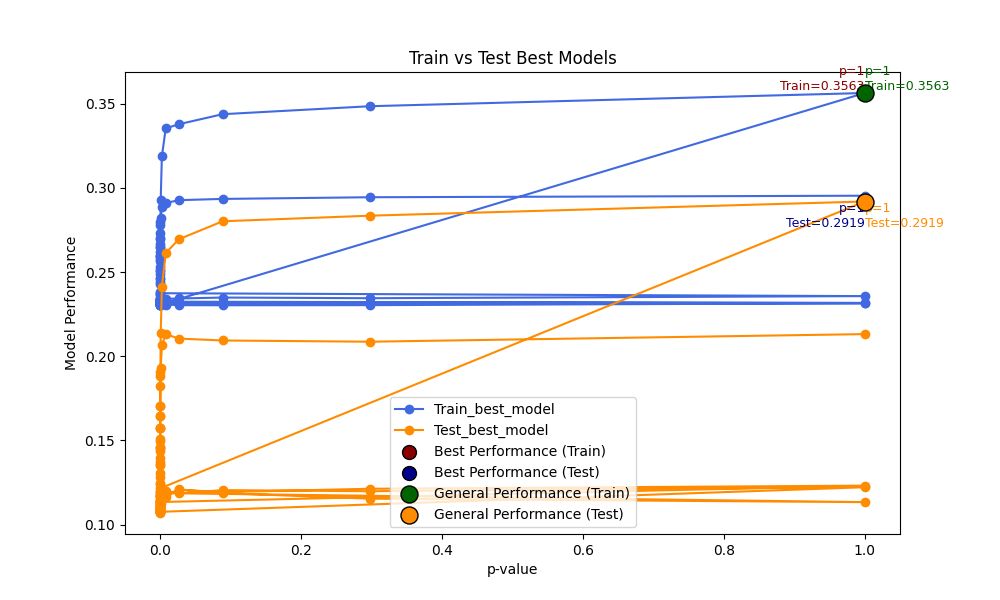

2. Reporting Generalized Performance:

|                  | 19                     |
|:-----------------|:-----------------------|
| clump_p1         | 1.0                    |
| clump_r2         | 0.1                    |
| clump_kb         | 200.0                  |
| p_window_size    | 200.0                  |
| p_slide_size     | 50.0                   |
| p_LD_threshold   | 0.25                   |
| pvalue           | 1.0                    |
| model            | 0.0                    |
| numberofpca      | 6.0                    |
| tempalpha        | 0.1                    |
| l1weight         | 0.1                    |
| h2               | 0.2032220489181616     |
| lambda           | 0.0                    |
| numberofvariants | 173107.8               |
| Train_pure_prs   | 3.1520625493497436e-06 |
| Train_null_model | 0.23001030414198947    |
| Train_best_model | 0.3563147420971411     |
| Test_pure_prs    | 3.1236905621900845e-06 |
| Test_null_model  | 0.11869244971793831 

<IPython.core.display.Javascript object>


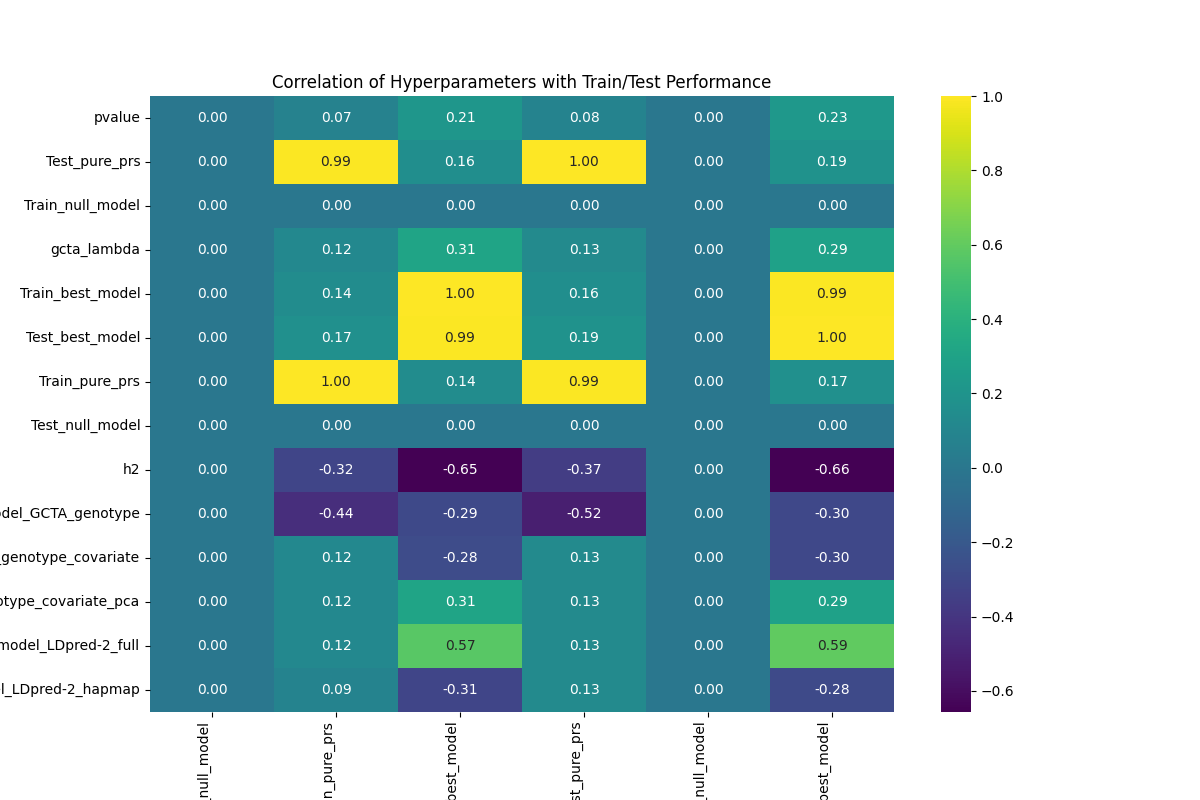

<IPython.core.display.Javascript object>


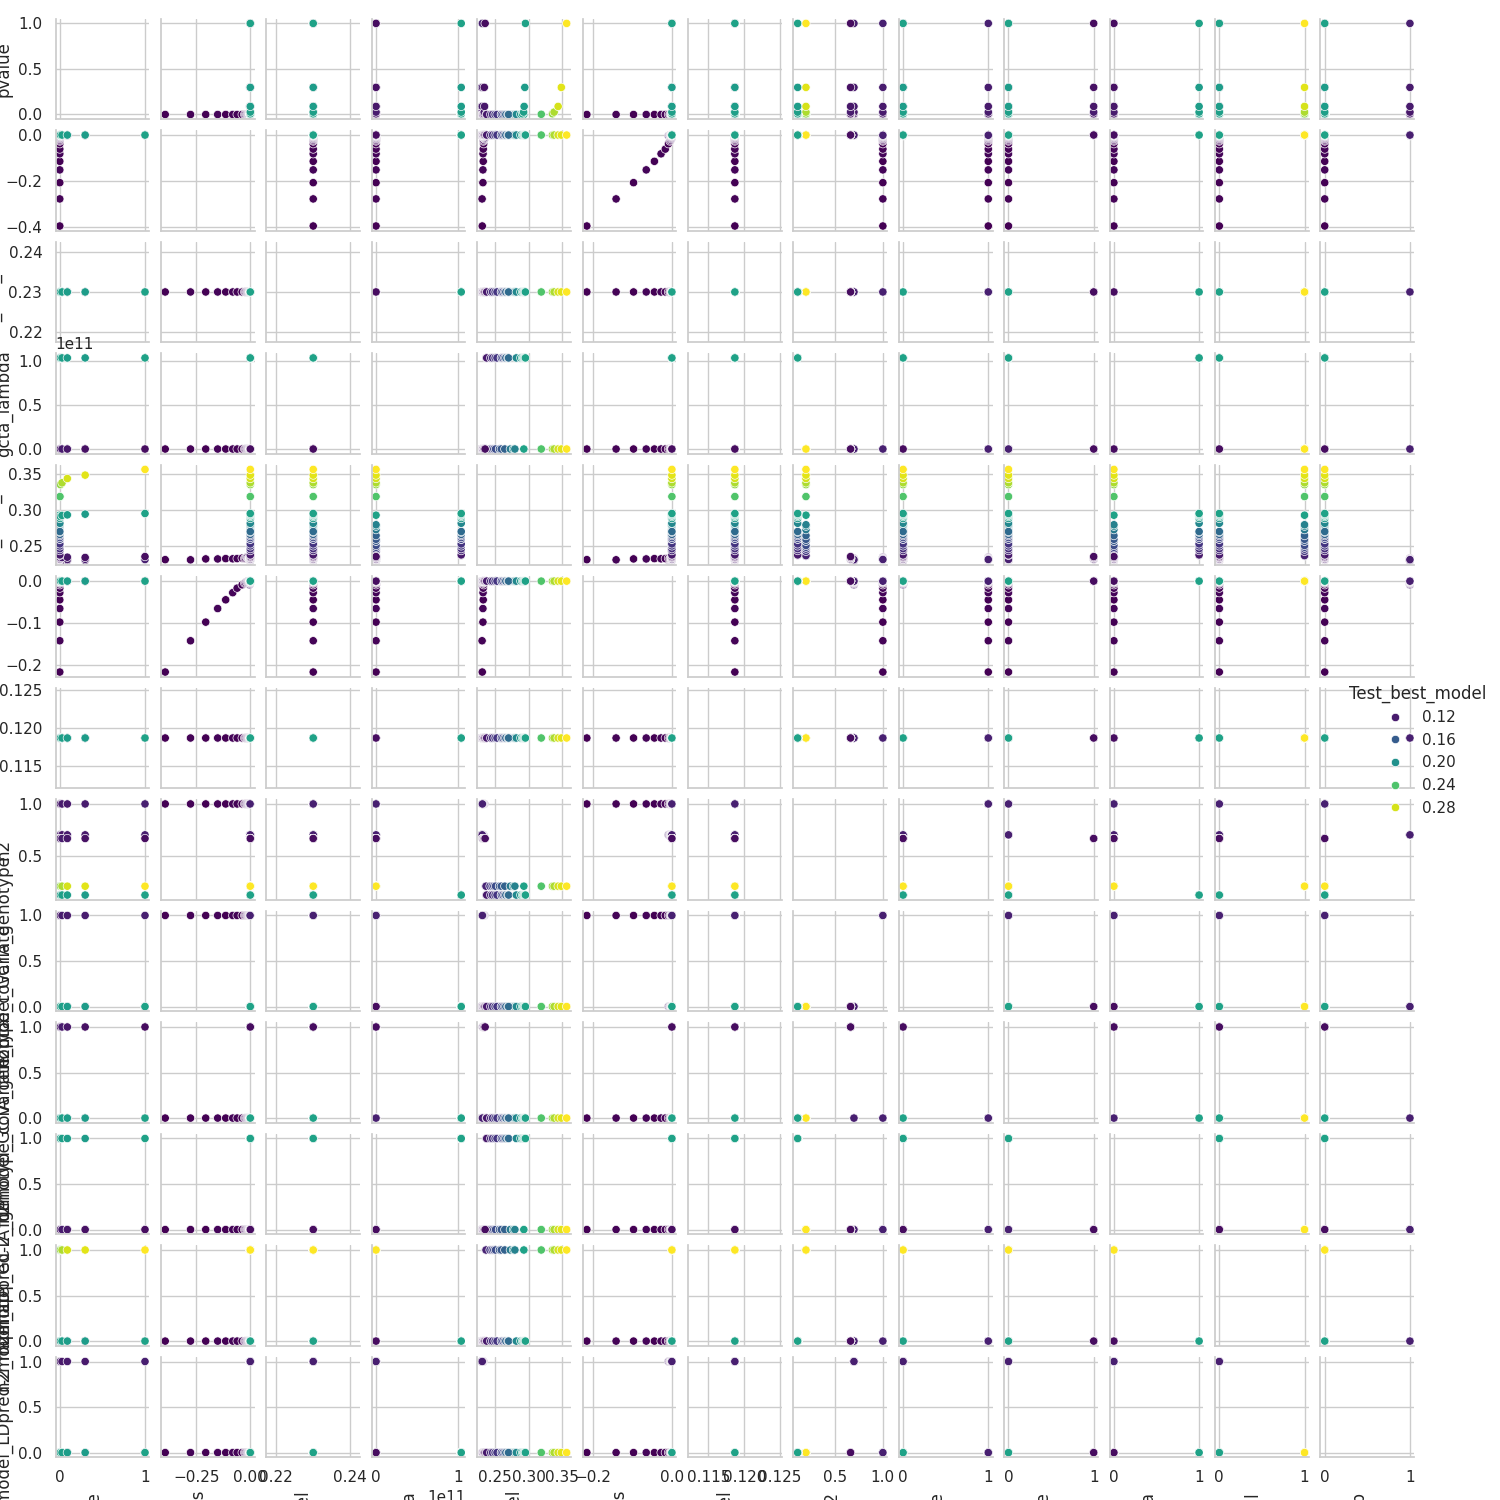

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook

df = divided_result.sort_values(by='Train_best_model', ascending=False)
print("1. Reporting Based on Best Training Performance:\n")
print(df.iloc[0].to_markdown())


 
df = divided_result.copy()

# Plot Train and Test best models against p-values
plt.figure(figsize=(10, 6))
plt.plot(df['pvalue'], df['Train_best_model'], label='Train_best_model', marker='o', color='royalblue')
plt.plot(df['pvalue'], df['Test_best_model'], label='Test_best_model', marker='o', color='darkorange')

# Highlight the p-value where both train and test are high
best_index = df[['Train_best_model']].sum(axis=1).idxmax()
best_pvalue = df.loc[best_index, 'pvalue']
best_train = df.loc[best_index, 'Train_best_model']
best_test = df.loc[best_index, 'Test_best_model']

# Use dark colors for the circles
plt.scatter(best_pvalue, best_train, color='darkred', s=100, label=f'Best Performance (Train)', edgecolor='black', zorder=5)
plt.scatter(best_pvalue, best_test, color='darkblue', s=100, label=f'Best Performance (Test)', edgecolor='black', zorder=5)

# Annotate the best performance with p-value, train, and test values
plt.text(best_pvalue, best_train, f'p={best_pvalue:.4g}\nTrain={best_train:.4g}', ha='right', va='bottom', fontsize=9, color='darkred')
plt.text(best_pvalue, best_test, f'p={best_pvalue:.4g}\nTest={best_test:.4g}', ha='right', va='top', fontsize=9, color='darkblue')

# Calculate Difference and Sum
df['Difference'] = abs(df['Train_best_model'] - df['Test_best_model'])
df['Sum'] = df['Train_best_model'] + df['Test_best_model']

# Sort the DataFrame
sorted_df = df.sort_values(by=['Sum', 'Difference'], ascending=[False, True])
#sorted_df = df.sort_values(by=[ 'Difference','Sum'], ascending=[  True,False])

# Highlight the general performance
general_index = sorted_df.index[0]
general_pvalue = sorted_df.loc[general_index, 'pvalue']
general_train = sorted_df.loc[general_index, 'Train_best_model']
general_test = sorted_df.loc[general_index, 'Test_best_model']

plt.scatter(general_pvalue, general_train, color='darkgreen', s=150, label='General Performance (Train)', edgecolor='black', zorder=6)
plt.scatter(general_pvalue, general_test, color='darkorange', s=150, label='General Performance (Test)', edgecolor='black', zorder=6)

# Annotate the general performance with p-value, train, and test values
plt.text(general_pvalue, general_train, f'p={general_pvalue:.4g}\nTrain={general_train:.4g}', ha='left', va='bottom', fontsize=9, color='darkgreen')
plt.text(general_pvalue, general_test, f'p={general_pvalue:.4g}\nTest={general_test:.4g}', ha='left', va='top', fontsize=9, color='darkorange')

# Add labels and legend
plt.xlabel('p-value')
plt.ylabel('Model Performance')
plt.title('Train vs Test Best Models')
plt.legend()
plt.show()
 




print("2. Reporting Generalized Performance:\n")
df = divided_result.copy()
df['Difference'] = abs(df['Train_best_model'] - df['Test_best_model'])
df['Sum'] = df['Train_best_model'] + df['Test_best_model']
sorted_df = df.sort_values(by=['Sum', 'Difference'], ascending=[False, True])
print(sorted_df.iloc[0].to_markdown())


print("3. Reporting the correlation of hyperparameters and the performance of 'Train_null_model', 'Train_pure_prs', 'Train_best_model', 'Test_pure_prs', 'Test_null_model', and 'Test_best_model':\n")

print("3. For string hyperparameters, we used one-hot encoding to find the correlation between string hyperparameters and 'Train_null_model', 'Train_pure_prs', 'Train_best_model', 'Test_pure_prs', 'Test_null_model', and 'Test_best_model'.")

print("3. We performed this analysis for those hyperparameters that have more than one unique value.")

correlation_columns = [
 'Train_null_model', 'Train_pure_prs', 'Train_best_model',
 'Test_pure_prs', 'Test_null_model', 'Test_best_model'
]

hyperparams = [col for col in divided_result.columns if len(divided_result[col].unique()) > 1]
hyperparams = list(set(hyperparams+correlation_columns))
 
# Separate numeric and string columns
numeric_hyperparams = [col for col in hyperparams if pd.api.types.is_numeric_dtype(divided_result[col])]
string_hyperparams = [col for col in hyperparams if pd.api.types.is_string_dtype(divided_result[col])]


# Encode string columns using one-hot encoding
divided_result_encoded = pd.get_dummies(divided_result, columns=string_hyperparams)

# Combine numeric hyperparams with the new one-hot encoded columns
encoded_columns = [col for col in divided_result_encoded.columns if col.startswith(tuple(string_hyperparams))]
hyperparams = numeric_hyperparams + encoded_columns
 

# Calculate correlations
correlations = divided_result_encoded[hyperparams].corr()
 
# Display correlation of hyperparameters with train/test performance columns
hyperparam_correlations = correlations.loc[hyperparams, correlation_columns]
 
hyperparam_correlations = hyperparam_correlations.fillna(0)

# Plotting the correlation heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(hyperparam_correlations, annot=True, cmap='viridis', fmt='.2f', cbar=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

# Rotate y-axis labels to horizontal
#ax.set_yticklabels(ax.get_yticklabels(), rotation=0, va='center')

plt.title('Correlation of Hyperparameters with Train/Test Performance')
plt.show() 

sns.set_theme(style="whitegrid")  # Choose your preferred style
pairplot = sns.pairplot(divided_result_encoded[hyperparams],hue = 'Test_best_model', palette='viridis')

# Adjust the figure size
pairplot.fig.set_size_inches(15, 15)  # You can adjust the size as needed

for ax in pairplot.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), rotation=90, ha='right')  # X-axis labels vertical
    #ax.set_ylabel(ax.get_ylabel(), rotation=0, va='bottom')  # Y-axis labels horizontal

# Show the plot
plt.show()


